In [1]:
###Matching Fermi-GBM and Swift Data###
import pandas as pd
import math
import gc
import julian
import numpy as np
from astropy.time import Time
import scipy.stats as st
import re
import datetime
from statistics import NormalDist
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pdb
import scipy.integrate as integrate
from scipy.optimize import fsolve

In [2]:
##Data import##
fermi_data=pd.read_csv('22_May_2023_Fermi_Data.csv')
swift_data=pd.read_csv('real swift bat data 3.csv')
swift_model_PL=pd.read_csv('swift_models_3_PL.csv')
swift_model_CPL=pd.read_csv('swift_models_3_PL.csv')
swift_fluxes_PL=pd.read_csv('swift_fluxes_3_PL.csv')
swift_fluxes_CPL=pd.read_csv('swift_fluxes_3_PL.csv')
swift_fluences_PL=pd.read_csv('swift_fluences_3_PL.csv')
swift_fluences_CPL=pd.read_csv('swift_fluences_3_PL.csv')
swift_fluences_reference=pd.read_csv('swift_fluences_3_match.csv')
swift_redshifts=pd.read_csv('swift_redshifts.csv')
second_redshifts=pd.read_csv("changed_alternative_GCN_redshifts.csv")
more_xrt_data=pd.read_csv('XRT_most_detailed_data.csv')
weird_xrt_data=pd.DataFrame.copy(more_xrt_data)
for k in range(0, len(weird_xrt_data)):
    weird_xrt_data['GRB '][k]='0{}'.format(weird_xrt_data['GRB '][k])
average_decay_data=pd.read_csv('Stage_2_decay_rates.csv')

/var/folders/v6/ssr7c_td4kz0ccw4r9cyww60r14wbw/T/ipykernel_44714/253958569.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weird_xrt_data['GRB '][k]='0{}'.format(weird_xrt_data['GRB '][k])


In [3]:
#God forbid I actually define a function#
def singly_broken_PL(amplitude, break1, power1, power2, t0, t):
    if t<break1 and t>t0:
        value=amplitude*t**(power1)
    elif t>=break1:
        value=amplitude*t**(power2)*break1**(power1-power2)
    else:
        value=np.NaN
    return value

def doubly_broken_PL(amplitude, break1, break2, power1, power2, power3, t0, t):
    if t<break1 and t>t0:
        value=amplitude*t**(power1)
    elif t>=break1 and t<break2:
        value=amplitude*t**(power2)*break1**(power1-power2)
    elif t>=break2:
        value=amplitude*t**(power3)*break1**(power1-power2)*break2**(power2-power3)
    else:
        value=np.NaN
    return value

def triply_broken_PL(amplitude, break1, break2, break3, power1, power2, power3, power4, t0,\
                     t):
    if t<break1 and t>t0:
        value=amplitude*t**(power1)
    elif t>=break1 and t<break2:
        value=amplitude*t**(power2)*break1**(power1-power2)
    elif t>=break2 and t<break3:
        value=amplitude*t**(power3)*break1**(power1-power2)*break2**(power2-power3)
    elif t>=break3:
        value=amplitude*t**(power4)*break1**(power1-power2)*break2**(power2-power3)*\
                              break3**(power3-power4)
    else:
        value=np.NaN
    return value

def quadruply_broken_PL(amplitude, break1, break2, break3, break4, power1, power2, power3,\
                        power4, power5, t0, t):
    if t<break1 and t>t0:
        value=amplitude*t**(power1)
    elif t>=break1 and t<break2:
        value=amplitude*t**(power2)*break1**(power1-power2)
    elif t>=break2 and t<break3:
        value=amplitude*t**(power3)*break1**(power1-power2)*break2**(power2-power3)
    elif t>=break3 and t<break4:
        value=amplitude*t**(power4)*break1**(power1-power2)*break2**(power2-power3)*\
                              break3**(power3-power4)
    elif t>=break4:
        value=amplitude*t**(power5)*break1**(power1-power2)*break2**(power2-power3)*\
                              break3**(power3-power4)*break4**(power4-power5)
    else:
        value=np.NaN
    return value

def quintuply_broken_PL(amplitude, break1, break2, break3, break4, break5, power1, power2,\
                        power3, power4, power5, power6, t0, t):
    if t<break1 and t>t0:
        value=amplitude*t**(power1)
    elif t>=break1 and t<break2:
        value=amplitude*t**(power2)*break1**(power1-power2)
    elif t>=break2 and t<break3:
        value=amplitude*t**(power3)*break1**(power1-power2)*break2**(power2-power3)
    elif t>=break3 and t<break4:
        value=amplitude*t**(power4)*break1**(power1-power2)*break2**(power2-power3)*\
                              break3**(power3-power4)
    elif t>=break4 and t<break5:
        value=amplitude*t**(power5)*break1**(power1-power2)*break2**(power2-power3)*\
                              break3**(power3-power4)*break4**(power4-power5)
    elif t>=break5:
        value=amplitude*t**(power6)*break1**(power1-power2)*break2**(power2-power3)*\
                              break3**(power3-power4)*break4**(power4-power5)*\
                                break5**(power5-power6)
    else:
        value=np.NaN
    return value

def singly_broken_PL_derivative(amplitude, break1, power1, power2, t0, t):
    if t<break1 and t>t0:
        value=amplitude*power_1*t**(power1-1)
    elif t>=break1:
        value=amplitude*power2*t**(power2-1)*break1**(power1-power2)
    else:
        value=np.NaN
    return value

def doubly_broken_PL_derivative(amplitude, break1, break2, power1, power2, power3, t0, t):
    if t<break1 and t>t0:
        value=amplitude*power1*t**(power1-1)
    elif t>=break1 and t<break2:
        value=amplitude*power2*t**(power2-1)*break1**(power1-power2)
    elif t>=break2:
        value=amplitude*power3*t**(power3-1)*break1**(power1-power2)*\
        break2**(power2-power3)
    else:
        value=np.NaN
    return value

def triply_broken_PL_derivative(amplitude, break1, break2, break3, power1, power2,\
                                power3, power4, t0, t):
    if t<break1 and t>t0:
        value=amplitude*power1*t**(power1-1)
    elif t>=break1 and t<break2:
        value=amplitude*power2*t**(power2-1)*break1**(power1-power2)
    elif t>=break2 and t<break3:
        value=amplitude*power3*t**(power3-1)*break1**(power1-power2)\
        *break2**(power2-power3)
    elif t>=break3:
        value=amplitude*power4*t**(power4-1)*break1**(power1-power2)*break2**(power2-power3)\
        *break3**(power3-power4)
    else:
        value=np.NaN
    return value

def quadruply_broken_PL_derivative(amplitude, break1, break2, break3, break4, power1,\
                                   power2, power3, power4, power5, t0, t):
    if t<break1 and t>t0:
        value=amplitude*power3*t**(power1-1)
    elif t>=break1 and t<break2:
        value=amplitude*power2*t**(power2-1)*break1**(power1-power2)
    elif t>=break2 and t<break3:
        value=amplitude*power3*t**(power3-1)*break1**(power1-power2)*break2**(power2-power3)
    elif t>=break3 and t<break4:
        value=amplitude*power4*t**(power4-1)*break1**(power1-power2)*break2**(power2-power3)\
        *break3**(power3-power4)
    elif t>=break4:
        value=amplitude*power5*t**(power5-1)*break1**(power1-power2)*break2**(power2-power3)\
        *break3**(power3-power4)*break4**(power4-power5)
    else:
        value=np.NaN
    return value

def quintuply_broken_PL_derivative(amplitude, break1, break2, break3, break4, break5, \
                                   power1, power2, power3, power4, power5, power6, t0, t):
    if t<break1 and t>t0:
        value=amplitude*power1*t**(power1-1)
    elif t>=break1 and t<break2:
        value=amplitude*power2*t**(power2-1)*break1**(power1-power2)
    elif t>=break2 and t<break3:
        value=amplitude*power3*t**(power3-1)*break1**(power1-power2)*break2**(power2-power3)
    elif t>=break3 and t<break4:
        value=amplitude*power4*t**(power4-1)*break1**(power1-power2)*break2**(power2-power3)\
        *break3**(power3-power4)
    elif t>=break4 and t<break5:
        value=amplitude*power5*t**(power5-1)*break1**(power1-power2)*break2**(power2-power3)\
        *break3**(power3-power4)*break4**(power4-power5)
    elif t>=break5:
        value=amplitude*power6*t**(power6-1)*break1**(power1-power2)*break2**(power2-power3)\
        *break3**(power3-power4)*break4**(power4-power5)*break5**(power5-power6)
    else:
        value=np.NaN
    return value

def defining_the_flux(tarjit, temporal_indices):
    flux_catch=' Obs Flux_{} (pc) '.format(tarjit+1)
    tarjete=tarjit+1
    xrt_flux=more_xrt_data[flux_catch][xrt_match]
    state=0
    if xrt_flux==' N/A ' or xrt_flux=='N/A' or xrt_flux=='NaN':
        flux_catch=' Obs Flux_{} (wt) '.format(tarjit+1)
        xrt_flux=more_xrt_data[flux_catch][xrt_match]
        state=1
        #weird case where sometimes XRT is still repointing or something, IDK.
        #It nets us 220101A, which is what I wanted.
    if tarjit==0:
        if xrt_flux==' N/A ' or xrt_flux=='N/A' or xrt_flux=='NaN':
            flux_catch=' Obs Flux_{} (pc) '.format(tarjit+2)
            xrt_flux=more_xrt_data[flux_catch][xrt_match]
            tarjete=tarjit+2
            state=0
            if xrt_flux==' N/A ' or xrt_flux=='N/A' or xrt_flux=='NaN':
                flux_catch=' Obs Flux_{} (wt) '.format(tarjit+2)
                xrt_flux=more_xrt_data[flux_catch][xrt_match]
                state=1
                #weird case where if it's at the very beginning, XRT
                #might not be measuring flux yet
    return flux_catch, xrt_flux, tarjete, state

def HR_err_func(S_top, S_bot, sig_S_top, sig_S_bot):
    HR_err=np.sqrt(np.power((sig_S_top/S_bot), 2)+np.power((S_top*sig_S_bot)/\
                                                          np.power(S_bot,2), 2))
    return HR_err

def Fermi_HR_func(relevant_fermi_data, spectral_model, entry):
    low_e_range=[15, 150]
    high_e_range=[150, 1500]
    if spectral_model=='flnc_plaw              ' or spectral_model==1:
        p_1=float(relevant_fermi_data.at[entry, 'flnc_plaw_index'])
        low_HR=integrate.quad(lambda x: power_law(x, p_1), low_e_range[0], \
                              low_e_range[1]) #PL
        high_HR=integrate.quad(lambda x: power_law(x, p_1), high_e_range[0], \
                              high_e_range[1]) #PL
        HR=high_HR[0]/low_HR[0]
        
    elif spectral_model=='flnc_comp              ' or spectral_model==2:
        p_1=float(relevant_fermi_data.at[entry, 'flnc_comp_index'])
        E_break=float(relevant_fermi_data.at[entry, 'flnc_comp_epeak'])
        low_HR=integrate.quad(lambda x:  Compton_PL(x, p_1, E_break), \
                       low_e_range[0], low_e_range[1]) #CPL
        high_HR=integrate.quad(lambda x: Compton_PL(x, p_1, E_break), \
                       high_e_range[0], high_e_range[1]) #CPL
        HR=high_HR[0]/low_HR[0]
        
    elif spectral_model=='flnc_band              ' or spectral_model==3:
        p_1=float(relevant_fermi_data.at[entry, 'flnc_band_alpha'])
        p_2=float(relevant_fermi_data.at[entry, 'flnc_band_beta'])
        E_break=float(relevant_fermi_data.at[entry, 'flnc_band_epeak'])
        low_HR=integrate.quad(lambda x: Band_function(x, E_break, p_1, p_2), \
                       low_e_range[0], low_e_range[1]) #Band
        high_HR=integrate.quad(lambda x: Band_function(x, E_break, p_1, p_2), \
                       high_e_range[0], high_e_range[1]) #Band
        HR=high_HR[0]/low_HR[0]
        
    elif spectral_model=='flnc_sbpl              ' or spectral_model==4:
        p_1=float(relevant_fermi_data.at[entry, 'flnc_sbpl_indx1'])
        p_2=float(relevant_fermi_data.at[entry, 'flnc_sbpl_indx2'])
        E_break=float(relevant_fermi_data.at[entry, 'flnc_sbpl_brken'])
        smoothen=float(relevant_fermi_data.at[entry, 'flnc_sbpl_brksc'])
        low_HR=integrate.quad(lambda x: Smoothly_Broken_PL(x, E_break, p_1, p_2, smoothen), \
                       low_e_range[0], low_e_range[1])
        high_HR=integrate.quad(lambda x: Smoothly_Broken_PL(x, E_break, p_1, p_2, smoothen),\
                       high_e_range[0], high_e_range[1])
        HR=high_HR[0]/low_HR[0]
        
    else:
        if relevant_fermi_data.at[entry, 'flnc_plaw_index']:
            p_1=float(relevant_fermi_data.at[entry, 'flnc_plaw_index'])
            low_HR=integrate.quad(lambda x: power_law(x, p_1), low_e_range[0], \
                                  low_e_range[1])
            high_HR=integrate.quad(lambda x: power_law(x, p_1), \
                               high_e_range[0], high_e_range[1]) 
            #PL because that's the simplest one, unfortunately
            HR=high_HR[0]/low_HR[0]
        else:
            HR=np.NA
    return HR

def swift_error_calculator(entry, fluence_table):
    if fluence_table.at[entry, ' 50_100kev_low '] != ' N/A ':
         HR_err_left = HR_err_func(float(fluence_table.at[entry, ' 50_100kev ']), \
                                float(fluence_table.at[entry, ' 25_50kev ']), \
                                float(fluence_table.at[entry,' 50_100kev_low ']), \
                                float(fluence_table.at[entry,' 25_50kev_low ']))
#         HR_err_left = (float(fluence_table.at[entry,' 50_100kev '])-\
#                         float(fluence_table.at[entry, ' 50_100kev_low ']))/\
#                             (float(fluence_table.at[entry, ' 25_50kev '])-\
#                                    float(fluence_table.at[entry,' 25_50kev_low ']))
    else:
        HR_err_left = 0
    if fluence_table.at[entry, ' 50_100kev_hi '] != ' N/A ':
         HR_err_right=HR_err_func(float(fluence_table.at[entry, ' 50_100kev ']),\
                                 float(fluence_table.at[entry, ' 25_50kev ']), \
                                 float(fluence_table.at[entry,' 50_100kev_hi ']), \
                             float(fluence_table.at[entry,' 25_50kev_hi ']))
#         HR_err_right = (float(fluence_table.at[entry, ' 50_100kev '])-\
#                         float(fluence_table.at[entry, ' 50_100kev_hi ']))/\
#                             (float(fluence_table.at[entry, ' 25_50kev '])-\
#                                    float(fluence_table.at[entry, ' 25_50kev_hi ']))
    else:
        HR_err_right = 0
    return [HR_err_left, HR_err_right]

def power_law (variable, index):
    value=variable**index
    return value

def Compton_PL (variable, index, break_E):
    value=np.power(variable, index)*np.exp(-variable/break_E)
    return value

def Band_function (variable, break_E, index_1, index_2):
    index_1=abs(index_1)
    index_2=abs(index_2)
    value=np.where(variable < ((index_1-index_2)*break_E)/(index_1), \
        ((variable/100)**index_2)*np.exp(index_2-index_1)*(((index_1-index_2)*\
        break_E)/(100*(index_1)))**(index_1-index_2), ((variable/100)**index_1)*\
        np.exp(-((index_1)*variable)/break_E))
    return np.real(value)

def Smoothly_Broken_PL (variable, break_E, index_1, index_2, smoothen):
    value=(variable/break_E)**(index_1)*(0.5*(1+(variable/break_E)**(1/smoothen)))**\
    (-(index_1-index_2)/smoothen)
    return value

def z_power_law(variable, index, redshift):
    value=(variable*(1+redshift))**(index)
    return value

def swift_fluence_function(burst_index, column_name):
    if swift_fluences_reference.at[burst_index, ' Best-fit model']==' PL':
        fluence=swift_fluences_PL.at[burst_index, column_name]
    elif swift_fluences_reference.at[burst_index, ' Best-fit model']==' CPL':
        fluence=swift_fluences_CPL.at[burst_index, column_name]
    else:
        fluence=np.NaN
    return fluence

def swift_flux_function(burst_index, column_name):
    if swift_fluences_reference.at[burst_index, ' Best-fit model']==' PL':
        flux=swift_fluxes_PL.at[burst_index, column_name]
    elif swift_fluences_reference.at[burst_index, ' Best-fit model']==' CPL':
        flux=swift_fluxes_CPL.at[burst_index, column_name]
    else:
        flux=np.NaN
    return flux

def swift_model_function(burst_index, column_name):
    if swift_fluences_reference.at[burst_index, ' Best-fit model']==' PL':
        model=swift_model_PL.at[burst_index, column_name]
    elif swift_fluences_reference.at[burst_index, ' Best-fit model']==' CPL':
        model=swift_model_CPL.at[burst_index, column_name]
    else:
        model=np.NaN
    return model

def getting_the_GBM_E_peak(relevant_fermi_data, spectral_model, entry):
    if spectral_model=='flnc_plaw              ' or spectral_model==1:
        if relevant_fermi_data.at[entry, 'flnc_comp_epeak']:
            E_peak=float(relevant_fermi_data.at[entry, 'flnc_comp_epeak'])
        elif relevant_fermi_data.at[entry, 'flnc_band_epeak']:
            E_peak=float(relevant_fermi_data.at[entry, 'flnc_band_epeak'])
        else:
            E_peak=np.NaN
    elif spectral_model=='flnc_comp              ' or spectral_model==2:
        E_peak=float(relevant_fermi_data.at[entry, 'flnc_comp_epeak'])
    elif spectral_model=='flnc_band              ' or spectral_model==3:
        E_peak=float(relevant_fermi_data.at[entry, 'flnc_band_epeak'])
    elif spectral_model=='flnc_sbpl              ' or spectral_model==4:
        E_peak=float(relevant_fermi_data.at[entry, 'flnc_sbpl_brken'])
    else:
        E_peak=np.NaN
    return E_peak

def getting_the_GBM_E_peak_err(relevant_fermi_data, spectral_model, entry):
    if spectral_model=='flnc_plaw              ' or spectral_model==1:
        if relevant_fermi_data.at[entry, 'flnc_comp_epeak']:
            E_peak_err=(abs(float(relevant_fermi_data.at[entry, 'flnc_comp_epeak_pos_err']))\
                +abs(float(relevant_fermi_data.at[entry, 'flnc_comp_epeak_neg_err'])))/2
        elif relevant_fermi_data.at[entry, 'flnc_band_epeak']:
            E_peak_err=(abs(float(relevant_fermi_data.at[entry, 'flnc_band_epeak_pos_err']))\
                +abs(float(relevant_fermi_data.at[entry, 'flnc_band_epeak_neg_err'])))/2
            #because np.mean SUDDENLY doesn't work on floats. >8(
        else:
            E_peak_err=np.NaN
    elif spectral_model=='flnc_comp              ' or spectral_model==2:
        E_peak_err=(abs(float(relevant_fermi_data.at[entry, 'flnc_comp_epeak_pos_err']))\
                +abs(float(relevant_fermi_data.at[entry, 'flnc_comp_epeak_neg_err'])))/2
    elif spectral_model=='flnc_band              ' or spectral_model==3:
        E_peak_err=(abs(float(relevant_fermi_data.at[entry, 'flnc_band_epeak_pos_err']))\
                +abs(float(relevant_fermi_data.at[entry, 'flnc_band_epeak_neg_err'])))/2
    elif spectral_model=='flnc_sbpl              ' or spectral_model==4:
        E_peak_err=(abs(float(relevant_fermi_data.at[entry, 'flnc_sbpl_brken_pos_err']))\
                +abs(float(relevant_fermi_data.at[entry, 'flnc_sbpl_brken_neg_err'])))/2
    else:
        E_peak_err=np.NaN
    return E_peak_err

def getting_the_BAT_E_peak(entry):
    if swift_fluences_reference.at[entry, ' Best-fit model']==' CPL':
        if swift_model_CPL.at[entry, ' Epeak '] != ' N/A ':
            E_peak=float(swift_model_CPL.at[entry, ' Epeak '])
        else:
            E_peak= np.NaN
    elif swift_fluences_reference.at[entry, ' Best-fit model']==' PL':
        if swift_model_CPL.at[entry, ' Epeak ']:
            if swift_model_CPL.at[entry, ' Epeak '] != ' N/A ':
                E_peak=float(swift_model_CPL.at[entry, ' Epeak '])
            else:
                E_peak= np.NaN
        else:
            E_peak= np.NaN
    else:
        E_peak=np.NaN
    return E_peak

def Fermi_k_func(relevant_fermi_data, spectral_model, entry, redshift):
    low_e_range=[10, 1000]
    high_e_range=[1/(1+redshift), 10000/(1+redshift)]
    if spectral_model=='flnc_plaw              ' or spectral_model==1:
        p_1=float(relevant_fermi_data.at[entry, 'flnc_plaw_index'])
        denominator=integrate.quad(lambda x: power_law(x, p_1), low_e_range[0], \
                              low_e_range[1]) #PL
        numerator=integrate.quad(lambda x: power_law(x, p_1), high_e_range[0], \
                              high_e_range[1]) #PL
        k=numerator[0]/denominator[0]
        
    elif spectral_model=='flnc_comp              ' or spectral_model==2:
        p_1=float(relevant_fermi_data.at[entry, 'flnc_comp_index'])
        E_break=float(relevant_fermi_data.at[entry, 'flnc_comp_epeak'])
        denominator=integrate.quad(lambda x:  Compton_PL(x, p_1, E_break), \
                       low_e_range[0], low_e_range[1]) #CPL
        numerator=integrate.quad(lambda x: Compton_PL(x, p_1, E_break), \
                       high_e_range[0], high_e_range[1]) #CPL
        k=numerator[0]/denominator[0]
        
    elif spectral_model=='flnc_band              ' or spectral_model==3:
        p_1=float(relevant_fermi_data.at[entry, 'flnc_band_alpha'])
        p_2=float(relevant_fermi_data.at[entry, 'flnc_band_beta'])
        E_break=float(relevant_fermi_data.at[entry, 'flnc_band_epeak'])
        denominator=integrate.quad(lambda x: Band_function(x, E_break, p_1, p_2), \
                       low_e_range[0], low_e_range[1]) #Band
        numerator=integrate.quad(lambda x: Band_function(x, E_break, p_1, p_2), \
                       high_e_range[0], high_e_range[1]) #Band
        k=numerator[0]/denominator[0]
        
    elif spectral_model=='flnc_sbpl              ' or spectral_model==4:
        p_1=float(relevant_fermi_data.at[entry, 'flnc_sbpl_indx1'])
        p_2=float(relevant_fermi_data.at[entry, 'flnc_sbpl_indx2'])
        E_break=float(relevant_fermi_data.at[entry, 'flnc_sbpl_brken'])
        smoothen=float(relevant_fermi_data.at[entry, 'flnc_sbpl_brksc'])
        denominator=integrate.quad(lambda x: Smoothly_Broken_PL(x, E_break, p_1, p_2, smoothen), \
                       low_e_range[0], low_e_range[1])
        numerator=integrate.quad(lambda x: Smoothly_Broken_PL(x, E_break, p_1, p_2, smoothen),\
                       high_e_range[0], high_e_range[1])
        k=numerator[0]/denominator[0]
        
    else:
        if relevant_fermi_data.at[entry, 'flnc_plaw_index']:
            p_1=float(relevant_fermi_data.at[entry, 'flnc_plaw_index'])
            denominator=integrate.quad(lambda x: power_law(x, p_1), low_e_range[0], \
                                  low_e_range[1])
            numerator=integrate.quad(lambda x: power_law(x, p_1), \
                               high_e_range[0], high_e_range[1]) 
            #PL because that's the simplest one, unfortunately
            k=numerator[0]/denominator[0]
        else:
            k=np.NA
    return k

def XRT_k_func(relevant_xrt_data, entry, redshift):
    low_e_range=[0.2, 10]
    high_e_range=[0.2/(1+redshift), 10/(1+redshift)]
    if float(relevant_xrt_data.at[entry, 'plaw_index']):
        p_1=-abs(float(relevant_xrt_data.at[entry, 'plaw_index']))
        denominator=integrate.quad(lambda x: power_law(x, p_1), low_e_range[0], \
                              low_e_range[1]) #PL
        numerator=integrate.quad(lambda x: power_law(x, p_1), high_e_range[0], \
                              high_e_range[1]) #PL
        k=np.real(numerator[0]/denominator[0])
    else:
        k=np.NaN
    return k

def kinetic_energy(nFn, beta, D_L, redshift, time, nu):
    time=((time/60)/60)/24
    nu=nu/(10**18)
    p=2*beta
    Y=1
    eps_e=0.1
    eps_b=0.01
    nFn_term=(nFn/(5.2*1e-14))**(4/(p+2))
    dist_term=((D_L*1e-28)**(8/(p+2)))
    rs_term=(1+redshift)**(-1)
    time_term=(time**((3*p-2)/(p+2)))*(1+Y)**(4/(p+2))
    if p != 2:
        fluxy_term=((6.73*((p-2)/(p-1))**(p-1))*((3.3*1e-6)**((p-2.3)/2)))**(-4/(p+2))
    else:
        #This is jsut a guess around the value given the other results, 
        #since p=2 is a discountinuity
        fluxy_term=((6.73*((p-1.9925)/(p-1))**(p-1))*((3.3*1e-6)**((p-2.3)/2)))**(-4/(p+2))
    carrier_dens_terms=((eps_e*1e1)**((4*(1-p))/(p+2)))*(eps_b*1e2)**((2-p)/(p+2))
    freq_term=(nu*1e-18)**((2*(p-2))/(p+2))
    E_k=nFn_term*dist_term*rs_term*time_term*fluxy_term*carrier_dens_terms*freq_term
    return E_k

def efficiency(E_k, E_g):
    eta=E_g/(E_g+E_k)
    return eta

def prompt_Eiso_error(d_lum, flu, relevant_fermi_data, spectral_model, entry, redshift):
    k=Fermi_k_func(sample_2_data, ghostie, fermi_placement, rs)
    S_err=(4*np.pi*((d_lum)**2)*1*k/(1+rs)*relevant_fermi_data[fermi_placement, \
                                                              'fluence_error'])**2
    low_e_range=[10, 1000]
    high_e_range=[1/(1+redshift), 10000/(1+redshift)]
    if spectral_model=='flnc_plaw              ' or spectral_model==1:
        p_1=float(relevant_fermi_data.at[entry, 'flnc_plaw_index'])
        denominator=integrate.quad(lambda x: power_law(x, p_1), low_e_range[0], \
                              low_e_range[1]) #PL
        numerator=integrate.quad(lambda x: power_law(x, p_1), high_e_range[0], \
                              high_e_range[1]) #PL
        q=numerator[0]/denominator[0]
        
    elif spectral_model=='flnc_comp              ' or spectral_model==2:
        p_1=float(relevant_fermi_data.at[entry, 'flnc_comp_index'])
        E_break=float(relevant_fermi_data.at[entry, 'flnc_comp_epeak'])
        denominator=integrate.quad(lambda x:  Compton_PL(x, p_1, E_break), \
                       low_e_range[0], low_e_range[1]) #CPL
        numerator=integrate.quad(lambda x: Compton_PL(x, p_1, E_break), \
                       high_e_range[0], high_e_range[1]) #CPL
        q=numerator[0]/denominator[0]
        
    elif spectral_model=='flnc_band              ' or spectral_model==3:
        p_1=float(relevant_fermi_data.at[entry, 'flnc_band_alpha'])
        p_2=float(relevant_fermi_data.at[entry, 'flnc_band_beta'])
        E_break=float(relevant_fermi_data.at[entry, 'flnc_band_epeak'])
        denominator=integrate.quad(lambda x: Band_function(x, E_break, p_1, p_2), \
                       low_e_range[0], low_e_range[1]) #Band
        numerator=integrate.quad(lambda x: Band_function(x, E_break, p_1, p_2), \
                       high_e_range[0], high_e_range[1]) #Band
        q=numerator[0]/denominator[0]
        
    elif spectral_model=='flnc_sbpl              ' or spectral_model==4:
        p_1=float(relevant_fermi_data.at[entry, 'flnc_sbpl_indx1'])
        p_2=float(relevant_fermi_data.at[entry, 'flnc_sbpl_indx2'])
        E_break=float(relevant_fermi_data.at[entry, 'flnc_sbpl_brken'])
        smoothen=float(relevant_fermi_data.at[entry, 'flnc_sbpl_brksc'])
        denominator=integrate.quad(lambda x: Smoothly_Broken_PL(x, E_break, p_1, p_2, smoothen), \
                       low_e_range[0], low_e_range[1])
        numerator=integrate.quad(lambda x: Smoothly_Broken_PL(x, E_break, p_1, p_2, smoothen),\
                       high_e_range[0], high_e_range[1])
        q=numerator[0]/denominator[0]
        
    else:
        if relevant_fermi_data.at[entry, 'flnc_plaw_index']:
            p_1=float(relevant_fermi_data.at[entry, 'flnc_plaw_index'])
            denominator=integrate.quad(lambda x: power_law(x, p_1), low_e_range[0], \
                                  low_e_range[1])
            numerator=integrate.quad(lambda x: power_law(x, p_1), \
                               high_e_range[0], high_e_range[1]) 
            #PL because that's the simplest one, unfortunately
            q=numerator[0]/denominator[0]
        else:
            q=np.NA
    return q

def afterglow_fluence_finder(spectral_sample_data, ag_instrument_data, placement):
    backstop=int(spectral_sample_data['Plateau Stage'][placement])+1
    row=spectral_sample_data['XRT row'][placement]
    model_selector=ag_instrument_data[' #breaks '][row]
    if model_selector>=1:
        break_1=int(float(ag_instrument_data[' break_1 '][row]))
        power_1=-float(ag_instrument_data[' alpha_1 '][row])
        power_2=-float(ag_instrument_data[' alpha_2 '][row])
        if backstop==1:
            front=0
            back=break_1
        if model_selector>=2:
            break_2=int(float(ag_instrument_data[' break_2 '][row]))
            back=break_2
            power_3=-float(ag_instrument_data[' alpha_3 '][row])
            if backstop==2:
                front=break_1
            if model_selector>=3:
                break_3=int(float(ag_instrument_data[' break_3 '][row]))
                back=break_3
                power_4=-float(ag_instrument_data[' alpha_4 '][row])
                if backstop==3:
                    front=break_2
                if model_selector>=4:
                    break_4=int(float(ag_instrument_data[' break_4 '][row]))
                    back=break_4
                    power_5=-float(ag_instrument_data[' alpha_5 '][row])
                    if backstop==4:
                        front=break_3
                    if model_selector==5:
                        break_5=int(float(ag_instrument_data[' break_5 '][row]))
                        back=break_5
                        power_6=-float(ag_instrument_data[' alpha_6 '][row]) 
                        if backstop==5:
                            front=break_4
                        initial_value=quintuply_broken_PL(1, break_1, break_2, break_3, \
                                    break_4, break_5, power_1, power_2, power_3, power_4, \
                                        power_5, power_6, 0, 11*60*60)
                        Q=fsolve(lambda A: A*initial_value-float(ag_instrument_data[' Flux_11 '][row]),\
                         0.01)[0]
                        if abs(quintuply_broken_PL(Q, break_1, break_2, break_3, break_4, \
                                break_5, power_1, power_2, power_3, power_4, power_5, power_6, \
                            0, 24*60*60)-float(ag_instrument_data[' Flux_24 '][row]))/\
                        (float(ag_instrument_data[' Flux_24 '][row]))<0.05:
                            AG_fluence=integrate.quad(lambda t: quintuply_broken_PL(Q, \
                                break_1, break_2, break_3, break_4, break_5, power_1, \
                                power_2, power_3, power_4, power_5, power_6, 0, t), \
                                                      front, back)[0]
                        else:
                            AG_fluence=np.NaN
                    else:
                        initial_value=quadruply_broken_PL(1, break_1, break_2, break_3, break_4, \
                                             power_1, power_2, power_3, power_4, power_5, \
                                             0, 11*60*60)
                        Q=fsolve(lambda A: A*initial_value-float(\
                                    ag_instrument_data[' Flux_11 '][row]),0.01)[0]
                        if abs(quadruply_broken_PL(Q, break_1, break_2, break_3, break_4, \
                            power_1, power_2, power_3, power_4, power_5,\
                            0, 24*60*60)-float(ag_instrument_data[' Flux_24 '][row]))/\
                        (float(ag_instrument_data[' Flux_24 '][row]))<0.05:
                            AG_fluence=integrate.quad(lambda t: quadruply_broken_PL(Q, \
                                break_1, break_2, break_3, break_4, power_1, power_2, \
                                power_3, power_4, power_5, 0, t), front, back)[0]
                        else:
                            AG_fluence=np.NaN
                else:
                    initial_value=triply_broken_PL(1, break_1, break_2, break_3, \
                                             power_1, power_2, power_3, power_4, \
                                             0, 11*60*60)
                    Q=fsolve(lambda A: A*initial_value-float(ag_instrument_data[' Flux_11 '][row]),\
                     0.01)[0]
                    if abs(triply_broken_PL(Q, break_1, break_2, break_3, \
                            power_1, power_2, power_3, power_4,\
                            0, 24*60*60)-float(ag_instrument_data[' Flux_24 '][row]))/\
                        (float(ag_instrument_data[' Flux_24 '][row]))<0.05:
                        AG_fluence=integrate.quad(lambda t: triply_broken_PL(Q, \
                                break_1, break_2, break_3, power_1, power_2, \
                                power_3, power_4, 0, t), front, back)[0]
                    else:
                        AG_fluence=np.NaN
            else:
                initial_value=doubly_broken_PL(1, break_1, break_2, \
                                             power_1, power_2, power_3, \
                                             0, 11*60*60)
                Q=fsolve(lambda A: A*initial_value-float(ag_instrument_data[' Flux_11 '][row]),\
                     0.01)[0]
                if abs(doubly_broken_PL(Q, break_1, break_2, power_1, power_2, power_3, \
                            0, 24*60*60)-float(ag_instrument_data[' Flux_24 '][row]))/\
                        (float(ag_instrument_data[' Flux_24 '][row]))<0.05:
                    AG_fluence=integrate.quad(lambda t: doubly_broken_PL(Q, \
                                break_1, break_2, power_1, power_2, \
                                power_3, 0, t), front, back)[0]
                else:
                    AG_fluence=np.NaN
        else:
            initial_value=singly_broken_PL(1, break_1, power_1, power_2, 0, 11*60*60)
            Q=fsolve(lambda A: A*initial_value-float(ag_instrument_data[' Flux_11 '][row]),\
                     0.01)[0]
            if abs(singly_broken_PL(Q, break_1, power_1, power_2, \
                            0, 24*60*60)-float(ag_instrument_data[' Flux_24 '][row]))/\
                        (float(ag_instrument_data[' Flux_24 '][row]))<0.05:
                AG_fluence=integrate.quad(lambda t: singly_broken_PL(Q, \
                                break_1, power_1, power_2, 0, t), front, back)[0]
            else:
                AG_fluence=np.NaN
    else:
        AG_fluence=np.NaN
    return AG_fluence

def afterglow_fluence_err_finder(spectral_sample_data, ag_instrument_data, placement):
    backstop=int(spectral_sample_data['Plateau Stage'][placement])+1
    row=spectral_sample_data['XRT row'][placement]
    model_selector=ag_instrument_data[' #breaks '][row]
    if model_selector>=1:
        break_1=int(float(ag_instrument_data[' break_1 '][row]))
        split_err=re.split(",", ag_instrument_data.at[placement, ' D_break_1 '].strip())
        if split_err and split_err[0] !='' and split_err[1] != '':
            split_err= list(map(float, split_err))
            err_break_1=np.mean([abs(split_err[0]), abs(split_err[1])])
        elif split_err[0] !='':
            err_break_1=float(split_err[0])
        elif split_err[1] != '':
            err_break_1=float(split_err[1])
        else:
            err_break_1=0
        power_1=-float(ag_instrument_data[' alpha_1 '][row])
        power_2=-float(ag_instrument_data[' alpha_2 '][row])
        if backstop==1:
            front=0
            error_front=0
            back=break_1
            error_back=float(err_break_1)
        if model_selector>=2:
            break_2=int(float(ag_instrument_data[' break_2 '][row]))
            split_err=re.split(",", ag_instrument_data.at[placement, ' D_break_2 '].strip())
            if split_err and split_err[0] !='' and split_err[1] != '':
                split_err= list(map(float, split_err))
                err_break_2=np.mean([abs(split_err[0]), abs(split_err[1])])
            elif split_err[0] !='':
                err_break_2=float(split_err[0])
            elif split_err[1] != '':
                err_break_2=float(split_err[1])
            else:
                err_break_2=0
            power_3=-float(ag_instrument_data[' alpha_3 '][row])
            if backstop==2:
                front=break_1
                error_front=float(err_break_1)
                back=break_2
                error_back=float(err_break_2)
            if model_selector>=3:
                break_3=int(float(ag_instrument_data[' break_3 '][row]))
                split_err=re.split(",", ag_instrument_data.at[placement, ' D_break_3 '].strip())
                if split_err and split_err[0] !='' and split_err[1] != '':
                    split_err= list(map(float, split_err))
                    err_break_3=np.mean([abs(split_err[0]), abs(split_err[1])])
                elif split_err[0] !='':
                    err_break_3=float(split_err[0])
                elif split_err[1] != '':
                    err_break_3=float(split_err[1])
                else:
                    err_break_3=0
                power_4=-float(ag_instrument_data[' alpha_4 '][row])
                if backstop==3:
                    front=break_2
                    error_front=float(err_break_2)
                    back=break_3
                    error_back=float(err_break_3)
                if model_selector>=4:
                    break_4=int(float(ag_instrument_data[' break_4 '][row]))
                    split_err=re.split(",", ag_instrument_data.at[placement, ' D_break_4 '].strip())
                    if split_err and split_err[0] !='' and split_err[1] != '':
                        split_err= list(map(float, split_err))
                        err_break_4=np.mean([abs(split_err[0]), abs(split_err[1])])
                    elif split_err[0] !='':
                        err_break_4=float(split_err[0])
                    elif split_err[1] != '':
                        err_break_4=float(split_err[1])
                    else:
                        err_break_4=0
                    power_5=-float(ag_instrument_data[' alpha_5 '][row])
                    if backstop==4:
                        front=break_3
                        error_front=float(err_break_3)
                        back=break_4
                        error_back=float(err_break_4)
                    if model_selector==5:
                        break_5=int(float(ag_instrument_data[' break_5 '][row]))
                        split_err=re.split(",", ag_instrument_data.at[placement, ' D_break_5 '].strip())
                        if split_err and split_err[0] !='' and split[1] != '':
                            split_err= list(map(float, split_err))
                            err_break_5=np.mean([abs(split_err[0]), abs(split_err[1])])
                        elif split_err[0] !='':
                            err_break_5=float(split_err[0])
                        elif split_err[1] != '':
                            err_break_5=float(split_err[1])
                        else:
                            err_break_5=0
                        power_6=-float(ag_instrument_data[' alpha_6 '][row]) 
                        if backstop==5:
                            front=break_4
                            error_back=float(err_break_4)
                            back=break_5
                            error_back=float(err_break_5)
                        initial_value=quintuply_broken_PL(1, break_1, break_2, break_3, \
                                    break_4, break_5, power_1, power_2, power_3, power_4, \
                                        power_5, power_6, 0, 11*60*60)
                        Q=fsolve(lambda A: A*initial_value-float(ag_instrument_data[' Flux_11 '][row]),\
                         0.01)[0]
                        if abs(quintuply_broken_PL(Q, break_1, break_2, break_3, break_4, \
                                break_5, power_1, power_2, power_3, power_4, power_5, power_6, \
                            0, 24*60*60)-float(ag_instrument_data[' Flux_24 '][row]))/\
                        (float(ag_instrument_data[' Flux_24 '][row]))<0.05:
                            AG_fluence=integrate.quad(lambda t: quintuply_broken_PL(Q, \
                                break_1, break_2, break_3, break_4, break_5, power_1, \
                                power_2, power_3, power_4, power_5, power_6, 0, t), \
                                                      front, back)[0]
                            AG_fluence_err=np.sqrt((\
                                quintuply_broken_PL_derivative(Q, break_1, break_2, break_3,\
                                break_4, break_5, power_1, power_2, power_3, power_4, power_5, \
                                power_6, 0, front)*error_front)**2+(\
                                quintuply_broken_PL_derivative(Q, break_1, break_2, break_3,\
                                break_4, break_5, power_1, power_2, power_3, power_4, power_5, \
                                power_6, 0, back)*error_back)**2)
                    else:
                        initial_value=quadruply_broken_PL(1, break_1, break_2, break_3, break_4, \
                                             power_1, power_2, power_3, power_4, power_5, \
                                             0, 11*60*60)
                        Q=fsolve(lambda A: A*initial_value-float(\
                                    ag_instrument_data[' Flux_11 '][row]),0.01)[0]
                        if abs(quadruply_broken_PL(Q, break_1, break_2, break_3, break_4, \
                            power_1, power_2, power_3, power_4, power_5,\
                            0, 24*60*60)-float(ag_instrument_data[' Flux_24 '][row]))/\
                        (float(ag_instrument_data[' Flux_24 '][row]))<0.05:
                            AG_fluence=integrate.quad(lambda t: quadruply_broken_PL(Q, \
                                break_1, break_2, break_3, break_4, power_1, power_2, \
                                power_3, power_4, power_5, 0, t), front, back)[0]
                            AG_fluence_err=np.sqrt((quadruply_broken_PL_derivative(Q, \
                                break_1, break_2, break_3, break_4, power_1, power_2, \
                                power_3, power_4, power_5, 0, front)*error_front)**2+(\
                                quadruply_broken_PL_derivative(Q, \
                                break_1, break_2, break_3, break_4, power_1, power_2, \
                                power_3, power_4, power_5, 0, back)*error_back)**2)
                else:
                    initial_value=triply_broken_PL(1, break_1, break_2, break_3, \
                                             power_1, power_2, power_3, power_4, \
                                             0, 11*60*60)
                    Q=fsolve(lambda A: A*initial_value-float(ag_instrument_data[' Flux_11 '][row]),\
                     0.01)[0]
                    if abs(triply_broken_PL(Q, break_1, break_2, break_3, \
                            power_1, power_2, power_3, power_4,\
                            0, 24*60*60)-float(ag_instrument_data[' Flux_24 '][row]))/\
                        (float(ag_instrument_data[' Flux_24 '][row]))<0.05:
                        AG_fluence=integrate.quad(lambda t: triply_broken_PL(Q, \
                                break_1, break_2, break_3, power_1, power_2, \
                                power_3, power_4, 0, t), front, back)[0]
                        AG_fluence_err=np.sqrt((triply_broken_PL_derivative(Q, \
                                break_1, break_2, break_3, power_1, power_2, \
                                power_3, power_4, 0, front)*error_front)**2+(\
                                triply_broken_PL_derivative(Q, \
                                break_1, break_2, break_3, power_1, power_2, \
                                power_3, power_4, 0, back)*error_back)**2)
            else:
                initial_value=doubly_broken_PL(1, break_1, break_2, \
                                             power_1, power_2, power_3, \
                                             0, 11*60*60)
                Q=fsolve(lambda A: A*initial_value-float(ag_instrument_data[' Flux_11 '][row]),\
                     0.01)[0]
                if abs(doubly_broken_PL(Q, break_1, break_2, power_1, power_2, power_3, \
                            0, 24*60*60)-float(ag_instrument_data[' Flux_24 '][row]))/\
                        (float(ag_instrument_data[' Flux_24 '][row]))<0.05:
                    AG_fluence=integrate.quad(lambda t: doubly_broken_PL(Q, \
                                break_1, break_2, power_1, power_2, \
                                power_3, 0, t), front, back)[0]
                    AG_fluence_err=np.sqrt((doubly_broken_PL_derivative(Q, \
                                break_1, break_2, power_1, power_2, \
                                power_3, 0, front)*error_front)**2+(\
                                doubly_broken_PL_derivative(Q, \
                                break_1, break_2, power_1, power_2, \
                                power_3, 0, back)*error_back)**2)
        else:
            initial_value=singly_broken_PL(1, break_1, power_1, power_2, 0, 11*60*60)
            Q=fsolve(lambda A: A*initial_value-float(ag_instrument_data[' Flux_11 '][row]),\
                     0.01)[0]
            if abs(singly_broken_PL(Q, break_1, power_1, power_2, \
                            0, 24*60*60)-float(ag_instrument_data[' Flux_24 '][row]))/\
                        (float(ag_instrument_data[' Flux_24 '][row]))<0.05:
                AG_fluence=integrate.quad(lambda t: singly_broken_PL(Q, \
                                break_1, power_1, power_2, 0, t), front, back)[0]
                AG_fluence_err=np.sqrt(\
                                (singly_broken_PL_derivative(1, break_1, power_1, power_2,\
                                0, front)*error_front**2\
                                 +(singly_broken_PL_derivative(1, break_1, power_1, \
                                power_2, 0, back)*error_back)**2))
    else:
        AG_fluence=np.NaN
    return AG_fluence_err

In [4]:
#Yeah, this dictionary will make life 500x easier later
Known_Precursors = {}
Known_Precursors["Long Collapsars"] = ('GRB050416A   ', 'GRB081007   ', 'GRB091127   ', \
                                       'GRB050525A   ', 'GRB050824   ', 'GRB060218   ', \
                                       'GRB060729   ', 'GRB060904B   ', 'GRB070419A   ', \
                                       'GRB071025   ', 'GRB071112C   ', 'GRB080109   ', \
                                       'GRB080319B   ', 'GRB081007A   ', 'GRB090618   ', \
                                       'GRB091127   ', 'GRB100316D   ', 'GRB100418A   ', \
                                       'GRB101219B   ', 'GRB101225A   ', 'GRB111209A   ', \
                                       'GRB111211A   ', 'GRB111228A   ', 'GRB120422A   ', \
                                       'GRB120714B   ', 'GRB120729A   ', 'GRB130215A   ', \
                                       'GRB130427A   ', 'GRB130702A   ', 'GRB130831A   ', \
                                       'GRB140206A   ', 'GRB140606B   ', 'GRB150818A   '\
                                       'GRB161219B   ', 'GRB161228B   ', 'GRB171010A   ', \
                                       'GRB171205A   ', 'GRB180720B   ', 'GRB180728A   ', \
                                       'GRB190114C   ', 'GRB190829A   ', 'GRB221009A   ', \
                                       'GRB211023A   ', 'GRB200826A   ', 'GRB210210A   ')
Known_Precursors["Short Collapsars"] = ('GRB200826A   ')
Known_Precursors["Short Mergers"] = ('GRB130603B   ', 'GRB160821B   ', 'GRB200522A   ', \
                                     'GRB150101B   ', 'GRB160624A   ', 'GRB170817A   ', \
                                     'GRB070809   ')
Known_Precursors["Long Mergers"] = ('GRB211211A   ', 'GRB230307A   ', 'GRB120304B   ', \
                                    'GRB111005A   ', 'GRB060614   ')
Known_Precursors["Potentially Exotic"] = ("GRB210704A   ")
Known_Precursors["Galactic Detected"] = ("GRB050509B   ", "GRB050709   ", "GRB051210    ", \
                                         "GRB070714B   ", "GRB071227    ", "GRB080503    ", \
                                         "GRB080905A   ", "GRB090515    ", "GRB160303A   ")
###
Fermi_Precursors = {}
Fermi_Precursors["Long Collapsars"] = ('GRB050416461', 'GRB050525002', 'GRB050824966', \
                                       'GRB060218148', 'GRB060729800', 'GRB060904104', \
                                       'GRB070419447', 'GRB071025172', 'GRB071112772', \
                                       'GRB080319258', 'GRB081007224', 'GRB090618353', \
                                       'GRB091127976', 'GRB100316531', 'GRB100418882', \
                                       'GRB101219686', 'GRB101225776', 'GRB111209300', \
                                       'GRB111211928', 'GRB111228656', 'GRB120422300', \
                                       'GRB120714888', 'GRB120729455', 'GRB130215063', \
                                       'GRB130427324', 'GRB130702003', 'GRB130831544', \
                                       'GRB140206303', 'GRB140606133', 'GRB150818483', \
                                       'GRB161219783', 'GRB161228552' ,'GRB171010792', \
                                       'GRB171205306', 'GRB180720598', 'GRB180728728', \
                                       'GRB190114872', 'GRB190829830', 'GRB200826187', \
                                       'GRB210210083', 'GRB211023545', 'GRB221009553')
Fermi_Precursors["Short Collapsars"] = ('GRB200826187')
Fermi_Precursors["Short Mergers"] = ('GRB070809807', 'GRB130603659', 'GRB150101641', \
                                     'GRB160624477', 'GRB160821936', 'GRB170817528', \
                                     'GRB200522487')
Fermi_Precursors["Long Mergers"] = ('GRB060614530', 'GRB111005336', 'GRB120304248', \
                                    'GRB211211548', 'GRB230307655')
Fermi_Precursors["Potentially Exotic"] = ('GRB210704814')
Fermi_Precursors["Galactic Detected"] = ('GRB050509166', 'GRB050709942', 'GRB051210240', \
                                         'GRB070714207', 'GRB071227842', 'GRB080503518', \
                                         'GRB080905499', 'GRB090515198', 'GRB160303454')
###
Overlap_Precursors = {}
Overlap_Precursors["Long Collapsars"] = (050416461.0, 50525002.0, 050824966.0, \
                                       060218148.0, 060729800.0, 060904104.0, \
                                       070419447.0, 071025172.0, 071112772.0, \
                                       080319258.0, 081007224.0, 090618353.0, \
                                       091127976.0, 100316531.0, 100418882.0, \
                                       101219686.0, 101225776.0, 111209300.0, \
                                       111211928.0, 111228656.0, 120422300.0, \
                                       120714888.0, 120729455.0, 130215063.0, \
                                       130427324.0, 130702003.0, 130831544.0, \
                                       140206303.0, 140606133.0, 150818483.0, \
                                       161219783.0, 161228552.0, 171010792.0, \
                                       171205306.0, 180720598.0, 180728728.0, \
                                       190114872.0, 190829830.0, 200826187.0, \
                                       210210083.0, 211023545.0, 221009553.0)
Overlap_Precursors["Short Collapsars"] = (200826187.0)
Overlap_Precursors["Short Mergers"] = (070809807.0, 130603659.0, 150101641.0, \
                                     160624477.0, 160821936.0, 170817528.0, \
                                     200522487.0)
Overlap_Precursors["Long Mergers"] = (060614530.0, 111005336.0, 120304248.0, \
                                    211211548.0, 230307655.0)
Overlap_Precursors["Potentially Exotic"] = (210704814.0)
Overlap_Precursors["Galactic Detected"] = (050509166.0, 050709942.0, 051210240.0, \
                                         070714207.0, 071227842.0, 080503518.0, \
                                         080905499.0, 090515198.0, 160303454.0)

In [5]:
##Creating Sample 0##
tiny_removals=[]
singular_swift_fluences_list=np.zeros((1,8))
singular_swift_fluxes_list=np.zeros((1,4))
singular_swift_models_list=np.zeros((1,7))
tarjete=0
stage=0
for i in range(0,len(swift_fluences_reference)):
    #for each event
    placeholder=[[swift_data.at[i, 'GRBname '], swift_fluence_function(i, ' 25_50kev '), \
                swift_fluence_function(i, ' 25_50kev_low '), \
                swift_fluence_function(i, ' 25_50kev_hi '), \
                swift_fluence_function(i, ' 50_100kev '),\
                                          swift_fluence_function(i, ' 50_100kev_low '),\
                                          swift_fluence_function(i, ' 50_100kev_hi '), 
                                          swift_fluence_function(i, ' 15_350kev ')]]
    singular_swift_fluences_list=np.append(singular_swift_fluences_list, \
                placeholder, axis=0)
    other_placeholder=[[swift_data.at[i, 'GRBname '], swift_flux_function(i, ' 15_350kev '), \
                swift_fluence_function(i, ' 15_350kev_low '), \
                swift_fluence_function(i, ' 15_350kev_hi ')]]
    singular_swift_fluxes_list=np.append(singular_swift_fluxes_list, \
                other_placeholder, axis=0)
    third_placeholder=[[swift_data.at[i, 'GRBname '], swift_model_function(i, ' alpha '), \
                swift_model_function(i, ' alpha_low '), \
                        swift_model_function(i, ' alpha_hi '), \
                        swift_model_function(i, ' Epeak '), \
                        swift_model_function(i, ' Epeak_low '), \
                        swift_model_function(i, ' Epeak_hi ')]]
    singular_swift_models_list=np.append(singular_swift_models_list, \
                third_placeholder, axis=0)
singular_swift_fluences_list=singular_swift_fluences_list[1:]
singular_swift_fluxes_list=singular_swift_fluxes_list[1:]
singular_swift_models_list=singular_swift_models_list[1:]
swift_fluences=pd.DataFrame(singular_swift_fluences_list, columns=['GRBname ', ' 25_50kev ',\
                                                                  ' 25_50kev_low ', \
                                                                   ' 25_50kev_hi ', \
                                                                   ' 50_100kev ', \
                                                                   ' 50_100kev_low ', \
                                                                   ' 50_100kev_hi ', \
                                                                   ' 15_350kev '])
swift_fluxes=pd.DataFrame(singular_swift_fluxes_list, columns=['GRBname ', ' 15_350kev ',\
                                                                  ' 15_350kev_low ', \
                                                                   ' 15_350kev_hi '])
swift_models=pd.DataFrame(singular_swift_models_list, columns=['GRBname ', ' alpha ', \
                                                               ' alpha_low ', \
                                                               ' alpha_hi ', \
                                                              ' E_peak ', ' E_peak_low ', \
                                                              ' E_peak_hi '])
for i in range(0,len(swift_fluences_reference)):
    test_flux=swift_fluxes.at[i,' 15_350kev ']
    test_direction=swift_data['  RA_ground   '][i]
    test_time=swift_data['     T90      '][i]
    if test_direction==' N/A ' or test_direction=='N/A':
            tiny_removals.append(i)
    elif test_time==' N/A ' or test_time=='N/A':
            tiny_removals.append(i)
    elif test_flux==' N/A ':
            tiny_removals.append(i)
if (len(swift_fluxes)-1)<(len(swift_data)-1):
    for k in range(len(swift_fluxes)-1, len(swift_data)):
        tiny_removals.append(k)
sample_0_data = swift_data.drop(index=tiny_removals)
print(len(sample_0_data))
print(len(swift_fluences))
print(len(swift_fluxes))
print(len(swift_models))
print(len(swift_data))

1501
1525
1525
1525
1564


In [6]:
##Creating Samples 1 and 4##
removals=[]
xrt_matches=np.zeros((1,2))
xrt_stages=np.zeros((1,2))
xrt_avg_slope=np.zeros((1,2))
tarjete=0
stage=0
for i in range(0,len(swift_fluxes)):
    #for each event
    query=swift_data[' XRT_detection '][i]
    #query the XRT detection then add it to the first empty list
    #print(swift_fluxes.at[i,' 15_350kev '])
    test_flux=swift_fluxes.at[i,' 15_350kev ']
    test_direction=swift_data['  RA_ground   '][i]
    test_time=swift_data['     T90      '][i]
    #snap=swift_data['GRBname '][i].strip()[3:]
#     if swift_data['GRBname '][i]=='GRB080503    ':
    if len(np.where(swift_data['GRBname '][i].strip()[3:]==more_xrt_data['GRB '])[0])>0 \
    or len(np.where(swift_data['GRBname '][i][3:].strip()==weird_xrt_data['GRB '])[0])>0:
#         if swift_data['GRBname '][i].strip()[3:]=='211211A':
        if len(np.where(swift_data['GRBname '][i].strip()[3:]==more_xrt_data['GRB '])[0])>0:
            xrt_match=np.where(swift_data['GRBname '][i].strip()[3:]==\
                               more_xrt_data['GRB '])[0][0]
        elif len(np.where(swift_data['GRBname '][i].strip()[3:]==\
                          weird_xrt_data['GRB '])[0])>0:
            xrt_match=np.where(swift_data['GRBname '][i].strip()[3:]==
                               weird_xrt_data['GRB '])[0][0]
        #         xrt_trigger=xrt_data['Trigger Number'][xrt_match]
#         test_pindex=swift_pindex['GRB'][xrt_match]
#         xrt_flux=more_xrt_data[' Obs Flux_2 (pc) '][xrt_match]
        #they're off becuase I downloaded them at different times.
#         if xrt_flux==' N/A ' or xrt_flux=='N/A' or xrt_flux=='NaN':
#             removals.append(i)
        temporal_indices=np.zeros(6)
        for l in range(0, 6):
            flux_name=' alpha_{} '.format(l+1)
            if more_xrt_data[flux_name][xrt_match]==' N/A ' \
                or more_xrt_data[flux_name][xrt_match]=='N/A' \
                or more_xrt_data[flux_name][xrt_match]=='NaN':
                temporal_indices[l]=-100 #just throw it out of range
            else:
                temporal_indices[l]=more_xrt_data[flux_name][xrt_match]
        if len(np.where((temporal_indices > -0.75) & (temporal_indices < 0.75))[0])>0:
            tarjit=np.where((temporal_indices > -0.75) & (temporal_indices < 0.75))[0][0]
            flux_catch, xrt_flux, tarjete, state=defining_the_flux(tarjit, temporal_indices)
            slope_index=[]
            slope_sum=0
            for m in range(0, 6):
                if m==tarjit-1:
                    continue
                elif temporal_indices[m]==-100:
                    continue
                else:
                    slope_index=np.append(slope_index, temporal_indices[m])
            if len(slope_index)>0:
                slope_sum=np.average(slope_index)
            else:
                slope_sum=0
#         elif (np.where(abs(temporal_indices)==min(abs(temporal_indices)))[0][0]>0) and \
#         min(abs(temporal_indices))<100:
#             tarjit=np.where(abs(temporal_indices)==min(abs(temporal_indices)))[0][0]
#             flux_catch, xrt_flux, tarjete, state=defining_the_flux(tarjit, temporal_indices)
        else:
            xrt_flux=' N/A '
        if xrt_flux==' N/A ' or xrt_flux=='N/A' or xrt_flux=='NaN':
            removals.append(i)
#             #anyway, we don't wnat the ones without flux right now
# #         elif test_pindex==' N/A ' or test_pindex=='N/A' or test_pindex=='NaN':
# #             removals.append(i)
# #         elif query!='Yes' and query!=' Yes ':
# #             #and add it to the second one if it didn't detect or it's not sure
# #             removals.append(i)
        if test_flux==' N/A ':
            removals.append(i)
        elif test_direction==' N/A ' or test_direction=='N/A':
            removals.append(i)
        elif test_time==' N/A ' or test_time=='N/A' or test_time=='     N/A      ':
            removals.append(i)
#         elif xrt_trigger=='BAT/GUANO':
            #These ones probably won't show up in the the data, but I don't want them
            #because they aren't relevant to what I'm doing, being that they /probably/ 
            #aren't triggered by Fermi and the data ends up missing everything relevant
#             removals.append(i)
        else:
            xrt_matches=np.append(xrt_matches,[[int(i),int(xrt_match)]], axis=0)
#             xrt_stages=np.append(xrt_stages,[[int(state),int(tarjete)]], axis=0)
#             xrt_avg_slope=np.append(xrt_avg_slope,[[int(i),int(slope_sum)]], axis=0)
            continue
    else:
        removals.append(i)
if (len(swift_fluxes)-1)<(len(swift_data)-1):
    for k in range(len(swift_fluxes)-1, len(swift_data)):
        removals.append(k)
edited_swift_data = swift_data.drop(index=removals)
xrt_matches=xrt_matches[1:]
# xrt_stages=xrt_stages[1:]
# xrt_avg_slope=xrt_avg_slope[1:]
test_flux=[]
for j in edited_swift_data.index:
    test_flux.append(swift_fluxes.at[j,' 15_350kev '])
red_swift_removals=[]
r=0
redshift_matches=np.zeros((1,2))
redshift_xrt=np.zeros((1,2))
# redshift_stages=np.zeros((1,2))
# redshift_avg_slope=np.zeros((1,2))
for j in edited_swift_data.index:
    for i in range(0, len(swift_redshifts)):
        swift_string=edited_swift_data['GRBname '][j].strip()
        redshift_string=swift_redshifts['GRBname '][i].strip()
        redsweefer = swift_redshifts.at[i, ' z '] #I call a swiffer a sweefer and 
        #this error was going to be a serious issue unlike the stupid question marks
        if swift_string==redshift_string:
            redshift_matches=np.append(redshift_matches,[[int(i),int(j)]], axis=0)
            row_match=int(np.where(xrt_matches[:, 0]==j)[0][0])
            redshift_xrt=np.append(redshift_xrt,[[int(j),xrt_matches[row_match,1]]], \
                                       axis=0)
#             redshift_stages=np.append(redshift_stages,[[int(xrt_stages[row_match,0]),
#                                                         int(xrt_stages[row_match,1])]], \
#                                       axis=0)
#             redshift_avg_slope=np.append(redshift_avg_slope,[[int(i),\
#                                                     int(xrt_avg_slope[row_match, 1])]],\
#                                          axis=0)
            if 'or' in str(redsweefer):
#                 print(redsweefer)
#                 print(redshift_string)
                red_swift_removals.append(j)
                redshift_xrt=redshift_xrt[:len(redshift_xrt)-1,:]
#                 redshift_stages=redshift_stages[:len(redshift_stages)-1,:]
#                 redshift_avg_slope=redshift_avg_slope[:len(redshift_stages)-1,:]
            if '-' in str(redsweefer):
                #whatever jerk did this one is okay in my book, not like ALL THE OTHER AWFUL
                #NONNUMERIC CHARACTERS AHHHHHHHHH, jerks, all the rest of you
                redswiffer=re.split("-", redsweefer.strip())
                red_broom = list(map(float, redswiffer))
                swift_redshifts.at[i, ' z ']=np.mean([red_broom[0], red_broom[1]])
            break
        elif swift_string != redshift_string and i==len(swift_redshifts)-1:
            r=r+1
            red_swift_removals.append(j)
        else: 
            continue
other_redshift_matches=np.zeros((1,2))
for j in edited_swift_data.index:
    for i in range(0, len(second_redshifts)):
        swift_string_2=edited_swift_data['GRBname '][j].strip()
        redshift_string_2=second_redshifts['GRB'][i].strip()
        redmop = second_redshifts.at[i, 'zc']
        if swift_string_2==redshift_string_2:
            other_redshift_matches=np.append(other_redshift_matches,[[int(i),int(j)]], axis=0)
            if type(red_swift_removals)!=int:
                if len(np.where(red_swift_removals==j)[0])>0:
                    add_in=np.where(red_swift_removals==j)[0][0]
                    red_swift_removals=np.delete(red_swift_removals,add_in)
            elif type(red_swift_removals)==int and red_swift_removals==j:
                red_swift_removals=[]
            #I /think/ this will add the removed ones back in. Probably.
            row_match=int(np.where(xrt_matches[:, 0]==j)[0][0])
            redshift_xrt=np.append(redshift_xrt,[[int(j),xrt_matches[row_match,1]]],\
                                   axis=0)
#             redshift_stages=np.append(redshift_stages,[[int(xrt_stages[row_match,0]),\
#                                                         int(xrt_stages[row_match,1])]],\
#                                       axis=0)
            break
#         elif swift_string_2 != redshift_string_2 and i==len(second_redshifts)-1:
#             red_swift_removals=np.append(red_swift_removals, j)
#             break
        else: 
            continue
# weird_removals=list(set(red_swift_removals))
redshift_matches=redshift_matches[1:]
redshift_xrt=redshift_xrt[1:]
# redshift_stages=redshift_stages[1:]
# redshift_avg_slope=redshift_avg_slope[1:]
redshift_swift_data = edited_swift_data.drop(index=red_swift_removals)
# print(len(edited_swift_data))
# print(len(redshift_swift_data))
edited_swift_data = swift_data.drop(index=removals)
sample_1_data=edited_swift_data
#For some reason I won't pretend to understand, creating sample 4 HERE prevents errors in 
#creating sample 3. Oy vey.
sample_4_data=redshift_swift_data
print(len(sample_1_data))
print(len(sample_4_data))

608
258


In [7]:
##Creating Sample 2##
sample_2_data=fermi_data
print(len(sample_2_data))

3527


In [8]:
##Creating Sample 3##
##Data conversion##
edited_indices=list(np.where(edited_swift_data.index!=0))
t=Time(edited_swift_data.at[int(edited_swift_data.index[0]),\
                            '       Trig_time_UTC        '].strip(), \
       format='isot', scale='utc')
gorp=t.jd; #honestly at this point I gave up on naming variables
shoes=float(edited_swift_data.at[int(edited_swift_data.index[0]),'  RA_ground   '])
sorks=float(edited_swift_data.at[int(edited_swift_data.index[0]),'     T90      '])
gatorade=float(edited_swift_data.at[int(edited_swift_data.index[0]), ' Image_position_err '])
helmet=float(edited_swift_data.at[int(edited_swift_data.index[0]),'  DEC_ground   '])
nom=str(edited_swift_data.at[int(edited_swift_data.index[0]),'GRBname '].strip())
for i in list(edited_swift_data.index):
    if type(edited_swift_data.at[i,'       Trig_time_UTC        '])==str:
        t=Time(edited_swift_data.at[i,'       Trig_time_UTC        '].strip(), \
               format='isot', scale='utc')
        gorp=np.append(gorp, t.jd)
        shoes=np.append(shoes, float(edited_swift_data.at[i,'  RA_ground   ']))
        sorks=np.append(sorks, float(edited_swift_data.at[i,'     T90      ']))
        gatorade=np.append(gatorade, float(edited_swift_data.at[i,' Image_position_err ']))
        helmet=np.append(helmet, float(edited_swift_data.at[i,'  DEC_ground   ']))
        nom=np.append(nom, str(edited_swift_data.at[i,'GRBname '].strip()))
    else :
        gorp=np.append(gorp, 1)
        sorks=np.append(sorks, float(edited_swift_data.at[i,'     T90      ']))
        shoes=np.append(shoes, float(edited_swift_data.at[i,'  RA_ground   ']))
        gatorade=np.append(gatorade, float(edited_swift_data.at[i,' Image_position_err ']))
        helmet=np.append(helmet, float(edited_swift_data.at[i,'  DEC_ground   ']))
        nom=np.append(nom, str(edited_swift_data.at[i,'GRBname '].strip()))
t0=fermi_data.at[0,"trigger_time           "]
t0=re.split("/| |:", t0)
t0 = list(map(int, t0))
t0=datetime.datetime(t0[2], t0[0], t0[1], t0[3], t0[4], t0[5], int(t0[6]))
trail_mix = julian.to_jd(t0, fmt='jd') #honestly at this point I gave up on naming variables
soles=fermi_data.at[0,'ra        ']
soles=soles.split(' ')
soles=list(map(float, soles)) 
boots=((soles[0]+(soles[1]+soles[2]/60)/60)*15)
fabric=fermi_data.at[0,'dec      ']
fabric=fabric.split(' ')
fabric=list(map(float, fabric)) 
hat=(fabric[0]+(fabric[1]+fabric[2]/60)/60)
socks=fermi_data.at[0,'t90_error']
w0ter=fermi_data.at[0, 'error_radius']
for i in range(1,len(fermi_data)):
    ti83=fermi_data.at[i,"trigger_time           "]
    ti83=re.split("/| |:", ti83)
    ti83 = list(map(int, ti83)) 
    ti83=datetime.datetime(ti83[2], ti83[0], ti83[1], ti83[3], ti83[4], ti83[5], \
                           int(ti83[6]))
    trail_mix = np.append(trail_mix, julian.to_jd(ti83, fmt='jd'))
    soles=fermi_data.at[i,'ra        ']
    soles=soles.split(' ')
    soles=list(map(float, soles)) 
    soles=((soles[0]+(soles[1]+soles[2]/60)/60)*15)
    boots=np.append(boots, soles)
    fabric=fermi_data.at[i,'dec      ']
    fabric=fabric.split(' ')
    fabric=list(map(float, fabric)) 
    fabric=(fabric[0]+(fabric[1]+fabric[2]/60)/60)
    hat=np.append(hat, fabric)
    socks=np.append(socks, fermi_data.at[i,'t90_error'])
    w0ter=np.append(w0ter, fermi_data.at[i,'error_radius'])
##match data##
food = np.zeros((len(trail_mix),len(gorp)))
feet_covers = np.zeros((len(trail_mix),len(gorp)))
UV_protection = np.zeros((len(trail_mix),len(gorp)))
k=0;
for i in range(0, len(gorp)):
    for j in range(0, len(trail_mix)):
        food[j, i] = abs(trail_mix[j]-gorp[i]);
        feet_covers[j, i] = abs(boots[j]-shoes[i]);
        UV_protection[j, i] = abs(hat[j]-helmet[i]);
        if food[j,i]<0.0035:
            if w0ter[j]<0.1:
                if feet_covers[j,i]<3*gatorade[i]:
                    if UV_protection[j,i]<3*gatorade[i]:
                        k=k+1;
            else:
                if feet_covers[j,i]<3*w0ter[j]:
                    if UV_protection[j,i]<3*w0ter[j]:
                        k=k+1;
matches = np.zeros((k+1, 15))
potential_matches=np.zeros((k,3))
print(k)
k=0;
err=0;
special_cases=[]
for i in range(0, len(gorp)):
    for j in range(0, len(trail_mix)):
        if food[j,i]<0.0035: #time
            if w0ter[j]<0.1:
                if feet_covers[j,i]<3*gatorade[i]: #RA
                    if UV_protection[j,i]<3*gatorade[i]: #dec
                        potential_matches[k,0]=food[j,i]
                        potential_matches[k,1]=w0ter[j]
                        potential_matches[k,2]=gatorade[i]
                        name=fermi_data.at[j,"name        "]
                        matches[k,0] = int(name[3]+name[4]+name[5]+name[6]+\
                                           name[7]+name[8]+name[9]+name[10]+name[11])
                        matches[k,1] = j
                        matches[k,2] = edited_swift_data.index[i]
                        if w0ter[j] != 0 and gatorade[i] != 0:
                            matches[k,3] = 1-NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes[i], sigma=gatorade[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet[i], sigma=gatorade[i])) #alpha
                            matches[k,4] = NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes[i], sigma=gatorade[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet[i], sigma=gatorade[i])) #beta
                        else:
                            matches[k,3]='NaN'
                            matches[k,4]='NaN'
                            err=err+1;
                        matches[k,5] = fermi_data.at[j,"t90     "]
                        matches[k,6] = fermi_data.at[j,"t90_error"]
                        matches[k,7] = fermi_data.at[j,'flux_256 ']
                        matches[k,8] = fermi_data.at[j,'fluence   ']
                        matches[k,9] = fermi_data.at[j,'fluence_error']
                        if swift_fluxes.at[edited_swift_data.index[i],\
                                                           ' 15_350kev '] != ' N/A ':
                            matches[k,10] = swift_fluxes.at[edited_swift_data.index[i],\
                                                               ' 15_350kev ']
                        else:
                            matches[k,10] = 0
                        if swift_fluences.at[edited_swift_data.index[i],\
                                                             ' 15_350kev '] != ' N/A ':
                            matches[k,11] =  swift_fluences.at[edited_swift_data.index[i],\
                                                             ' 15_350kev ']
                        else:
                            matches[k,11] = 0
                        if fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_plaw              ':
                            matches[k,12] = 1
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_band              ':
                            matches[k,12] = 2
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_comp              ':
                            matches[k,12] = 3
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_sbpl              ':
                            matches[k,12] = 4
                        else:
                            matches[k,12] = 0
                        #pdb.set_trace()
                        xrt_xcall=np.where(xrt_matches[:,0]==\
                                                 edited_swift_data.index[i-1])[0][0]
                        matches[k,13]=int(xrt_matches[xrt_xcall, 1])
#                         matches[k,14] = int(xrt_stages[i-1,1])
#     #                     matches[k, 11]=xrt_data.at[xrt_call,\
#     #                                         'XRT Early Flux (0.3-10 keV) [10^-11 erg/cm^2/s]']
#     #                     print(i-1)
#     #                     print(xrt_call)
#                         if int(xrt_stages[i-1,0])==0:
#                             flux_recall=' Obs Flux_{} (pc) '.\
#                                 format(int(xrt_stages[i-1,1]))
#                             flux_change=' D_Obs Flux_{} (pc) '.\
#                                     format(int(xrt_stages[i-1,1]))
#                         elif int(xrt_stages[i-1,0])==1:
#                             flux_recall=' Obs Flux_{} (wt) '.\
#                                 format(int(xrt_stages[i-1,1]))
#                             flux_change=' D_Obs Flux_{} (wt) '.\
#                                     format(int(xrt_stages[i-1,1]))
#                         else:
#                             print("error, this burst ({}) didn't get an assigned flux.").\
#                             format(fermi_data.at[j,"name        "])
#     #                     print(fermi_data.at[j,"name        "])
#     #                     print(flux_recall)
#     #                     print(more_xrt_data[flux_recall][xrt_call])
#                         matches[k, 13]=more_xrt_data[flux_recall][xrt_call]
#                         if more_xrt_data[flux_change][xrt_call]==' , ':
#                             matches[k,14]=0.34*float(more_xrt_data[flux_recall][xrt_call])
#                             matches[k,15]=0.34*float(more_xrt_data[flux_recall][xrt_call])
#                             #this is about one standard deviation
#                         elif ',' in str(more_xrt_data[flux_change][xrt_call]):
#                             dual_input=re.split(",", str(more_xrt_data[flux_change][xrt_call])\
#                                                 .strip())
#                             headphones = list(map(float, dual_input))
#                             matches[k,14]=headphones[0]
#                             matches[k,15]=headphones[1]
#                             #I originally only left room for one value. That was a mistake.
#                         else:
#                             matches[k, 14]=more_xrt_data[flux_change][xrt_call]
#                             matches[k, 15]=more_xrt_data[flux_change][xrt_call]
#                         matches[k,16]=xrt_avg_slope[xrt_xcall, 1]
                        k=k+1
            else:
                if feet_covers[j,i]<3*w0ter[j]: #RA
                    if UV_protection[j,i]<3*w0ter[j]: #dec
                        special_cases=np.append(special_cases,fermi_data.at[j,"name        "])
            
                        potential_matches[k,0]=food[j,i]
                        potential_matches[k,1]=w0ter[j]
                        potential_matches[k,2]=gatorade[i]
                        name=fermi_data.at[j,"name        "]
                        matches[k,0] = int(name[3]+name[4]+name[5]+name[6]+\
                                           name[7]+name[8]+name[9]+name[10]+name[11])
                        matches[k,1] = j
                        matches[k,2] = edited_swift_data.index[i]
                        if w0ter[j] != 0 and gatorade[i] != 0:
                            matches[k,3] = 1-NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes[i], sigma=gatorade[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet[i], sigma=gatorade[i])) #alpha
                            matches[k,4] = NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes[i], sigma=gatorade[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet[i], sigma=gatorade[i])) #beta
                        else:
                            matches[k,3]='NaN'
                            matches[k,4]='NaN'
                            err=err+1;
                        matches[k,5] = fermi_data.at[j,"t90     "]
                        matches[k,6] = fermi_data.at[j,"t90_error"]
                        matches[k,7] = fermi_data.at[j,'flux_256 ']
                        matches[k,8] = fermi_data.at[j,'fluence   ']
                        matches[k,9] = fermi_data.at[j,'fluence_error']
                        if swift_fluxes.at[edited_swift_data.index[i],\
                                                           ' 15_350kev '] != ' N/A ':
                            matches[k,10] = swift_fluxes.at[edited_swift_data.index[i],\
                                                               ' 15_350kev ']
                        else:
                            matches[k,10] = 0
                        if swift_fluences.at[edited_swift_data.index[i],\
                                                             ' 15_350kev '] != ' N/A ':
                            matches[k,11] = swift_fluences.at[edited_swift_data.index[i],\
                                                             ' 15_350kev ']
                        else:
                            matches[k,11] = 0
                        if fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_plaw              ':
                            matches[k,12] = 1
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_band              ':
                            matches[k,12] = 2
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_comp              ':
                            matches[k,12] = 3
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_sbpl              ':
                            matches[k,12] = 4
                        else:
                            matches[k,12] = 0
                        xrt_xcall=np.where(xrt_matches[:,0]==\
                                                 edited_swift_data.index[i-1])[0][0]
                        matches[k,13]=int(xrt_matches[xrt_xcall, 1])
#                         matches[k,14] = int(xrt_stages[i-1,1])
#                         if int(xrt_stages[i-1,0])==0:
#                             flux_recall=' Obs Flux_{} (pc) '.\
#                                 format(int(xrt_stages[i-1,1]))
#                             flux_change=' D_Obs Flux_{} (pc) '.\
#                                     format(int(xrt_stages[i-1,1]))
#                         elif int(xrt_stages[i-1,0])==1:
#                             flux_recall=' Obs Flux_{} (wt) '.\
#                                 format(int(xrt_stages[i-1,1]))
#                             flux_change=' D_Obs Flux_{} (wt) '.\
#                                     format(int(xrt_stages[i-1,1]))
#                         else:
#                             print("error, this burst ({}) didn't get an assigned flux.").\
#                             format(fermi_data.at[j,"name        "])
#                         matches[k, 13]=more_xrt_data[flux_recall][xrt_call]
#                         if more_xrt_data[flux_change][xrt_call]==' , ':
#                             matches[k,14]=0.34*float(more_xrt_data[flux_recall][xrt_call])
#                             matches[k,15]=0.34*float(more_xrt_data[flux_recall][xrt_call])
#                             #this is about one standard deviation
#                         elif ',' in str(more_xrt_data[flux_change][xrt_call]):
#                             dual_input=re.split(",", str(more_xrt_data[flux_change][xrt_call])\
#                                                 .strip())
#                             headphones = list(map(float, dual_input))
#                             matches[k,14]=headphones[0]
#                             matches[k,15]=headphones[1]
#                             #I originally only left room for one value. That was a mistake.
#                         else:
#                             matches[k, 14]=more_xrt_data[flux_change][xrt_call]
#                             matches[k, 15]=more_xrt_data[flux_change][xrt_call]
#                         matches[k,16]=xrt_avg_slope[xrt_xcall, 1]
                        k=k+1
regular_matches=pd.DataFrame(matches, columns=['name', 'Fermi row', 'Swift row',\
                                               'Type I error', \
                                       'Type II error', 't90', 't90_error', 'GBM flux', \
                                       'GBM fluence', 'Fluence error',\
                                               'BAT flux', 'BAT fluence',\
                                               'Spectral Model', 'XRT row', \
                                               'Plateau Stage'])#,\
#                                                '"Plateau" X-Ray Flux', \
#                                                "Pre-X-ray Flux Change", \
#                                                "Post-X-ray Flux Change"])
regular_matches=regular_matches[:-1]
sample_3_data=regular_matches
print(special_cases)

163
['GRB111201599' 'GRB110319815']


In [9]:
##Creating Sample 6##
##Data conversion fo the redshift data##
start_index=redshift_swift_data.index[0]
t2=Time(redshift_swift_data.at[start_index,'       Trig_time_UTC        '].strip(), \
               format='isot', scale='utc')
gorp2=t2.jd; #honestly at this point I gave up on naming variables
shoes2=float(redshift_swift_data.at[start_index,'  RA_ground   '])
sorks2=float(redshift_swift_data.at[start_index,'     T90      '])
gatorade2=float(redshift_swift_data.at[start_index, ' Image_position_err '])
helmet2=float(redshift_swift_data.at[start_index,'  DEC_ground   '])
nom2=str(redshift_swift_data.at[start_index,'GRBname '].strip())
for i in list(redshift_swift_data.index):
    if i !=redshift_swift_data.index[0]:
        if type(redshift_swift_data.at[i,'       Trig_time_UTC        '])==str:
            t2=Time(redshift_swift_data.at[i,'       Trig_time_UTC        '].strip(), \
               format='isot', scale='utc')
            gorp2=np.append(gorp2, t2.jd)
            shoes2=np.append(shoes2, float(redshift_swift_data.at[i,'  RA_ground   ']))
            sorks2=np.append(sorks2, float(redshift_swift_data.at[i,'     T90      ']))
            gatorade2=np.append(gatorade2, \
                            float(redshift_swift_data.at[i,' Image_position_err ']))
            helmet2=np.append(helmet2, float(redshift_swift_data.at[i,'  DEC_ground   ']))
            nom2=np.append(nom2, str(redshift_swift_data.at[i,'GRBname '].strip()))
        else:
            gorp2=np.append(gorp2, 1)
            sorks2=np.append(sorks2, float(redshift_swift_data.at[i,'     T90      ']))
            shoes2=np.append(shoes2, float(redshift_swift_data.at[i,'  RA_ground   ']))
            gatorade2=np.append(gatorade2, \
                            float(redshift_swift_data.at[i,' Image_position_err ']))
            helmet2=np.append(helmet2, float(redshift_swift_data.at[i,'  DEC_ground   ']))
            nom2=np.append(nom2, str(redshift_swift_data.at[i,'GRBname '].strip()))
        #Honestly, all the Fermi stuff already existed, so I deleted it
    else:
        continue
##Match the Redshift Data too ##
food_2 = np.zeros((len(trail_mix),len(gorp2)))
feet_covers_2 = np.zeros((len(trail_mix),len(gorp2)))
UV_protection_2 = np.zeros((len(trail_mix),len(gorp2)))
l=0;
for i in range(0, len(gorp2)):
    for j in range(0, len(trail_mix)):
        food_2[j, i] = abs(trail_mix[j]-gorp2[i]);
        feet_covers_2[j, i] = abs(boots[j]-shoes2[i]);
        UV_protection_2[j, i] = abs(hat[j]-helmet2[i]);
        if food_2[j,i]<0.0035:
            if w0ter[j]<0.1:
                if feet_covers_2[j,i]<3*gatorade2[i]:
                    if UV_protection_2[j,i]<3*gatorade2[i]:
                        l=l+1;
            else:
                if feet_covers[j,i]<3*w0ter[j]:
                    if UV_protection[j,i]<3*w0ter[j]:
                        l=l+1;
z_matches = np.zeros((l+1, 16))
z_potential_matches=np.zeros((l+1,3))
print(l)
l=0;
err=0;
special_cases=[]
for i in range(0, len(gorp2)-1):
    for j in range(0, len(trail_mix)-1):
        if food_2[j,i]<0.0035: #time
            if w0ter[j]<0.1:
                if feet_covers_2[j,i]<3*gatorade2[i]: #RA
                    if UV_protection_2[j,i]<3*gatorade2[i]: #dec
                        z_potential_matches[l,0]=food_2[j,i]
                        z_potential_matches[l,1]=w0ter[j]
                        z_potential_matches[l,2]=gatorade2[i]
                        name=fermi_data.at[j,"name        "]
                        z_matches[l,0] = int(name[3]+name[4]+name[5]+name[6]+\
                                           name[7]+name[8]+name[9]+name[10]+name[11])
                        z_matches[l,1] = j
                        z_matches[l,2] = redshift_swift_data.index[i]
                        if w0ter[j] != 0 and gatorade2[i] != 0:
                            z_matches[l,3] = 1-NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes2[i], sigma=gatorade2[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet2[i], sigma=gatorade2[i])) #alpha
                            z_matches[l,4] = NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes2[i], sigma=gatorade2[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet2[i], sigma=gatorade2[i])) #beta
                        else:
                            z_matches[l,3]='NaN'
                            z_matches[l,4]='NaN'
                            err=err+1;
                        z_matches[l,5] = fermi_data.at[j,"t90     "]
                        z_matches[l,6] = fermi_data.at[j,"t90_error"]
                        z_matches[l,7] = fermi_data.at[j,'flux_256 ']
                        z_matches[l,8] = fermi_data.at[j,'fluence   ']
                        z_matches[l,9] = fermi_data.at[j,'fluence_error']
                        if swift_fluxes.at[redshift_swift_data.index[i],\
                                                           ' 15_350kev '] != ' N/A ':
                            z_matches[l,10] = swift_fluxes.at[redshift_swift_data.index[i],\
                                                           ' 15_350kev ']
                        else:
                            z_matches[l,10] = 0
                        if swift_fluences.at[redshift_swift_data.index[i],\
                                                             ' 15_350kev '] != ' N/A ':
                            z_matches[l,11] = swift_fluences.at[redshift_swift_data.index[i],\
                                                             ' 15_350kev ']
                        else:
                            z_matches[l, 11] = 0
                        if fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_plaw              ':
                            z_matches[l,12] = 1
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_band              ':
                            z_matches[l,12] = 2
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_comp              ':
                            z_matches[l,12] = 3
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_sbpl              ':
                            z_matches[l,12] = 4
                        else:
                            z_matches[l,12] = 0
                        z_matches[l,13] = int(redshift_xrt[i, 1])
#                         z_matches[l,14] = int(redshift_stages[i,1])
#                         if int(redshift_stages[i,0])==0:
#                             flux_recall=' Obs Flux_{} (pc) '.\
#                                 format(int(redshift_stages[i,1]))
#                             flux_change=' D_Obs Flux_{} (pc) '.\
#                                 format(int(redshift_stages[i,1]))
#                         elif int(redshift_stages[i,0])==1:
#                             flux_recall=' Obs Flux_{} (wt) '.\
#                                 format(int(redshift_stages[i,1]))
#                             flux_change=' D_Obs Flux_{} (wt) '.\
#                                 format(int(redshift_stages[i,1]))
#                         else:
#                             print("error, this burst ({}) didn't get an assigned flux.").\
#                             format(fermi_data.at[j,"name        "])
#                         z_matches[l, 13]=more_xrt_data[flux_recall][xrt_call]
#                         if more_xrt_data[flux_change][xrt_call]==' , ':
#                             z_matches[l,14]=0.34*float(more_xrt_data[flux_recall][xrt_call])
#                             z_matches[l,15]=0.34*float(more_xrt_data[flux_recall][xrt_call])
#                             #this is about one standard deviation
#                         elif ',' in str(more_xrt_data[flux_change][xrt_call]):
#                             dual_input=re.split(",", str(more_xrt_data[flux_change][xrt_call])\
#                                                 .strip())
#                             headphones = list(map(float, dual_input))
#                             z_matches[l,14]=headphones[0]
#                             z_matches[l,15]=headphones[1]
#                             #I originally only left room for one value. That was a mistake.
#                         else:
#                             z_matches[l, 14]=more_xrt_data[flux_change][xrt_call]
#                             z_matches[l, 15]=more_xrt_data[flux_change][xrt_call]
#                         z_matches[l,16]=redshift_avg_slope[i, 1]
                        if len(np.where(redshift_matches[:,1]==\
                                        redshift_swift_data.index[i])[0])>0:
                            redshift_recall=np.where(redshift_matches[:,1]==\
                                                     redshift_swift_data.index[i])[0][0]
                            redshift_call=redshift_matches[redshift_recall, 0]
                            z_matches[l,15] = float(swift_redshifts.at[redshift_call, ' z ']\
                                                .strip().replace('(?)', '')\
                                                .replace('?', '').replace('<', '').\
                                               replace('>', ''))
                            #z_matches[l, 15] = 0
                        elif len(np.where(other_redshift_matches[:,1]==\
                                        redshift_swift_data.index[i])[0])>0:
                            redshift_recall=np.where(other_redshift_matches[:,1]==\
                                                     redshift_swift_data.index[i])[0][0]
                            redshift_call=redshift_matches[redshift_recall, 0]
                            z_matches[l,15] = float(swift_redshifts.at[redshift_call, ' z ']\
                                                .strip().replace('(?)', '')\
                                                .replace('?', '').replace('<', '').\
                                               replace('>', ''))
                            #z_matches[l, 15] = 1
                        l=l+1;
            else:
                if feet_covers_2[j,i]<3*w0ter[j]: #RA
                    if UV_protection_2[j,i]<3*w0ter[j]: #dec
                        special_cases=np.append(special_cases,fermi_data.at[j,"name        "])
                        z_potential_matches[l,0]=food_2[j,i]
                        z_potential_matches[l,1]=w0ter[j]
                        z_potential_matches[l,2]=gatorade2[i]
                        name=fermi_data.at[j,"name        "]
                        z_matches[l,0] = int(name[3]+name[4]+name[5]+name[6]+\
                                           name[7]+name[8]+name[9]+name[10]+name[11])
                        z_matches[l,1] = j
                        z_matches[l,2] = redshift_swift_data.index[i]
                        if w0ter[j] != 0 and gatorade2[i] != 0:
                            z_matches[l,3] = 1-NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes2[i], sigma=gatorade2[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet2[i], sigma=gatorade2[i])) #alpha
                            z_matches[l,4] = NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes2[i], sigma=gatorade2[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet2[i], sigma=gatorade2[i])) #beta
                        else:
                            z_matches[l,3]='NaN'
                            z_matches[l,4]='NaN'
                            err=err+1;
                        z_matches[l,5] = fermi_data.at[j,"t90     "]
                        z_matches[l,6] = fermi_data.at[j,"t90_error"]
                        z_matches[l,7] = fermi_data.at[j,'flux_256 ']
                        z_matches[l,8] = fermi_data.at[j,'fluence   ']
                        z_matches[l,9] = fermi_data.at[j,'fluence_error']
                        z_matches[l,10] = swift_fluxes.at[redshift_swift_data.index[i],\
                                                           ' 15_350kev ']
                        z_matches[l,11] = swift_fluences.at[redshift_swift_data.index[i],\
                                                             ' 15_350kev ']
                        if fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_plaw              ':
                            z_matches[l,12] = 1
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_band              ':
                            z_matches[l,12] = 2
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_comp              ':
                            z_matches[l,12] = 3
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_sbpl              ':
                            z_matches[l,12] = 4
                        else:
                            z_matches[l,12] = 0
#                         xrt_xcall=np.where(redshift_xrt[:,0]==i)[0][0]
                        z_matches[l,13]=int(redshift_xrt[i, 1])
#                         z_matches[l,14] = int(redshift_stages[i,1])
    #                     matches[k, 11]=xrt_data.at[xrt_call,\
    #                                         'XRT Early Flux (0.3-10 keV) [10^-11 erg/cm^2/s]']
    #                     print(i)
    #                     print(xrt_call)
#                         if int(redshift_stages[i,0])==0:
#                             flux_recall=' Obs Flux_{} (pc) '.\
#                                 format(int(redshift_stages[i,1]))
#                             flux_change=' D_Obs Flux_{} (pc) '.\
#                                 format(int(redshift_stages[i,1]))
#                         elif int(redshift_stages[i,0])==1:
#                             flux_recall=' Obs Flux_{} (wt) '.\
#                                 format(int(redshift_stages[i,1]))
#                             flux_change=' D_Obs Flux_{} (wt) '.\
#                                 format(int(redshift_stages[i,1]))
#                         else:
#                             print("error, this burst ({}) didn't get an assigned flux.").\
#                             format(fermi_data.at[j,"name        "])
    #                     print(fermi_data.at[j,"name        "])
    #                     print(redshift_swift_data.at[redshift_swift_data.index[i], 'GRBname '])
    #                     print(flux_recall)
    #                     print(more_xrt_data[flux_recall][xrt_call])
#                         z_matches[l, 13]=more_xrt_data[flux_recall][xrt_call]
#                         if more_xrt_data[flux_change][xrt_call]==' , ':
#                             z_matches[l,14]=0.34*float(more_xrt_data[flux_recall][xrt_call])
#                             z_matches[l,15]=0.34*float(more_xrt_data[flux_recall][xrt_call])
#                             #this is about one standard deviation
#                         elif ',' in str(more_xrt_data[flux_change][xrt_call]):
#                             dual_input=re.split(",", str(more_xrt_data[flux_change][xrt_call])\
#                                                 .strip())
#                             headphones = list(map(float, dual_input))
#                             z_matches[l,14]=headphones[0]
#                             z_matches[l,15]=headphones[1]
#                             #I originally only left room for one value. That was a mistake.
#                         else:
#                             z_matches[l, 14]=more_xrt_data[flux_change][xrt_call]
#                             z_matches[l, 15]=more_xrt_data[flux_change][xrt_call]
#                         z_matches[l,16]=redshift_avg_slope[i, 1]
    #                     z_matches[l,15]=max(more_xrt_data[' Ave_obs_flux_WT '][xrt_call],\
    #                                       more_xrt_data[' Ave_obs_flux_PC '][xrt_call])
    #                     avg_flux=np.where([more_xrt_data[' Ave_obs_flux_WT '][xrt_call],\
    #                                       more_xrt_data[' Ave_obs_flux_PC '][xrt_call]]==\
    #                             max(more_xrt_data[' Ave_obs_flux_WT '][xrt_call],\
    #                                       more_xrt_data[' Ave_obs_flux_PC '][xrt_call]))
    #                     if avg_flux==0:
    #                         z_matches[l, 16]=more_xrt_data[' d_Ave_obs_flux_WT '][xrt_call]
    #                     elif avg_flux==1:
    #                         z_matches[l, 16]=more_xrt_data[' d_Ave_obs_flux_PC '][xrt_call]
                        if len(np.where(redshift_matches[:,1]==\
                                        redshift_swift_data.index[i])[0])>0:
                            redshift_recall=np.where(redshift_matches[:,1]==\
                                                     redshift_swift_data.index[i])[0][0]
                            redshift_call=redshift_matches[redshift_recall, 0]
                            z_matches[l,15] = float(swift_redshifts.at[redshift_call, ' z ']\
                                                .strip().replace('(?)', '')\
                                                .replace('?', '').replace('<', '').\
                                               replace('>', ''))
                            #z_matches[l, 15] = 0
                        elif len(np.where(other_redshift_matches[:,1]==\
                                        redshift_swift_data.index[i])[0])>0:
                            redshift_recall=np.where(other_redshift_matches[:,1]==\
                                                     redshift_swift_data.index[i])[0][0]
                            redshift_call=redshift_matches[redshift_recall, 0]
                            z_matches[l,15] = float(swift_redshifts.at[redshift_call, ' z ']\
                                                .strip().replace('(?)', '')\
                                                .replace('?', '').replace('<', '').\
                                               replace('>', ''))
                            #z_matches[l, 15] = 1
                        l=l+1;
redshifted_matches=pd.DataFrame(z_matches, columns=['name', 'Fermi row', 'Swift row', \
                                                    'Type I error', \
                                       'Type II error', 't90', 't90_error', 'GBM flux', \
                                       'GBM fluence', 'Fluence error',\
                                                    'BAT flux', 'BAT fluence',\
                                                    'Spectral Model', 'XRT row', \
                                                    'Plateau Stage',\
#                                                '"Plateau" X-Ray Flux',\
#                                                "Pre-X-ray Flux Change", \
#                                                "Post-X-ray Flux Change",\
                                                    'Likely Redshift'])
redshifted_matches=redshifted_matches[:-1]
sample_6_data=redshifted_matches
print(special_cases)

64
[]


12
13
14
16
16


/var/folders/v6/ssr7c_td4kz0ccw4r9cyww60r14wbw/T/ipykernel_44714/1692380094.py:227: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  low_HR=integrate.quad(lambda x: power_law(x, p_1), low_e_range[0], \
/var/folders/v6/ssr7c_td4kz0ccw4r9cyww60r14wbw/T/ipykernel_44714/1692380094.py:229: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  high_HR=integrate.quad(lambda x: power_law(x, p_1), \


3528


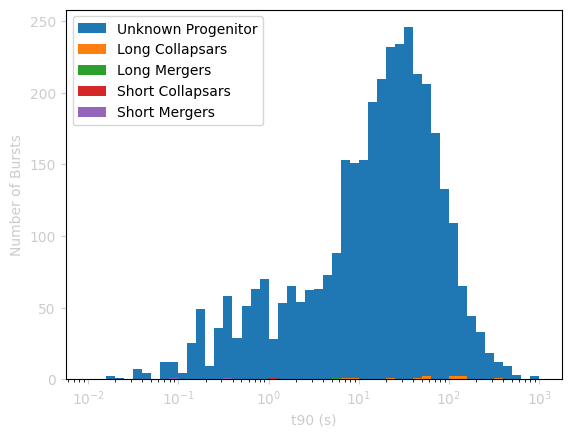

There are 12 known long collapsars, 1 known long mergers, 2 known short mergers, 1 known short collapsars, and 0 known exotic GRBs in Sample 2.
There are 2311/3527 bursts in total


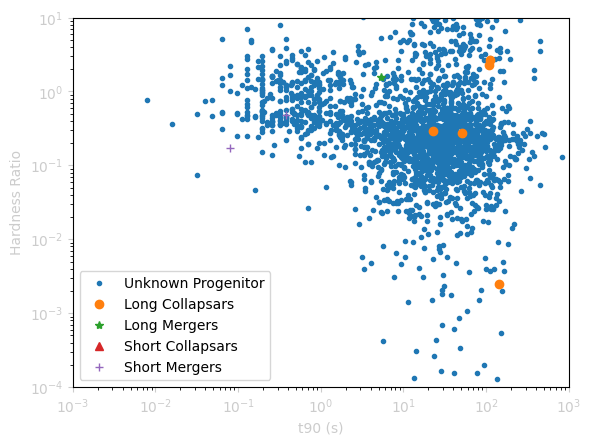

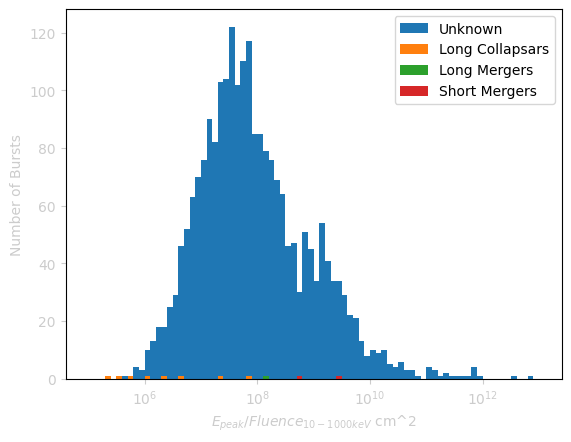

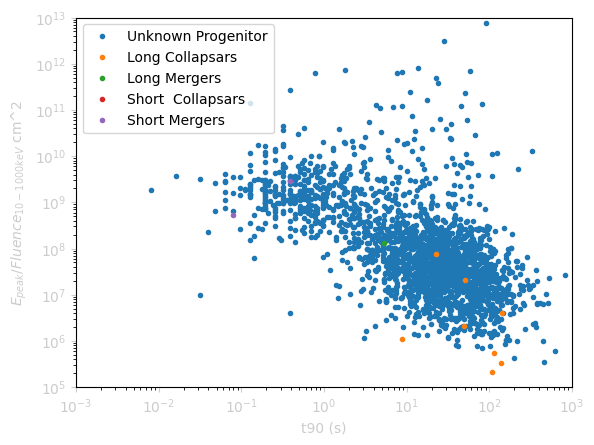

In [10]:
##Sample 2 Diagnositics##
#unknown_progenitor_edited_fermi_data=fermi_data
unknown_progenitor_HR=[]
unknown_progenitor_HR_err=np.zeros((1,2))
unknown_progenitor_t90=[]
unknown_progenitor_t90_err=[]
unknown_progenitor_Epeak_over_s=[]
unknown_progenitor_Epeak_over_s_err=[]
unknown_progenitor_Epeak=[]
unknown_progenitor_Epeak_err=[]
unknown_progenitor_flu=[]
unknown_progenitor_flu_err=[]
long_merger_HR=[]
long_merger_HR_err=np.zeros((1,2))
long_merger_t90=[]
long_merger_t90_err=[]
long_merger_Epeak_over_s=[]
long_merger_Epeak_over_s_err=[]
long_merger_Epeak=[]
long_merger_Epeak_err=[]
long_merger_flu=[]
long_merger_flu_err=[]
short_merger_HR=[]
short_merger_HR_err=np.zeros((1,2))
short_merger_t90=[]
short_merger_t90_err=[]
short_merger_Epeak_over_s=[]
short_merger_Epeak_over_s_err=[]
short_merger_Epeak=[]
short_merger_Epeak_err=[]
short_merger_flu=[]
short_merger_flu_err=[]
long_collapsar_HR=[]
long_collapsar_HR_err=np.zeros((1,2))
long_collapsar_t90=[]
long_collapsar_t90_err=[]
long_collapsar_Epeak_over_s=[]
long_collapsar_Epeak_over_s_err=[]
long_collapsar_Epeak=[]
long_collapsar_Epeak_err=[]
long_collapsar_flu=[]
long_collapsar_flu_err=[]
short_collapsar_HR=[]
short_collapsar_HR_err=np.zeros((1,2))
short_collapsar_t90=[]
short_collapsar_t90_err=[]
short_collapsar_Epeak_over_s=[]
short_collapsar_Epeak_over_s_err=[]
short_collapsar_Epeak=[]
short_collapsar_Epeak_err=[]
short_collapsar_flu=[]
short_collapsar_flu_err=[]
exotic_HR=[]
exotic_HR_err=np.zeros((1,2))
exotic_t90=[]
exotic_t90_err=[]
exotic_Epeak_over_s=[]
exotic_Epeak_over_s_err=[]
exotic_Epeak=[]
exotic_Epeak_err=[]
exotic_flu=[]
exotic_flu_err=[]
Initial_Goldstein_Data=np.zeros((len(sample_2_data)+1,10))
p=0
nbins=51
lc_mask=np.isin(sample_2_data['name        '], Fermi_Precursors["Long Collapsars"])
lc_sample_2_data=sample_2_data[lc_mask]
for i in lc_sample_2_data.index.to_list():
    long_collapsar_HR=np.append(long_collapsar_HR, Fermi_HR_func(sample_2_data, \
                                sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    long_collapsar_t90=np.append(long_collapsar_t90, float(sample_2_data.at[i, 't90     ']))
    long_collapsar_Epeak=np.append(long_collapsar_Epeak, getting_the_GBM_E_peak(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    long_collapsar_flu=np.append(long_collapsar_flu, float(sample_2_data.at[i, 'fluence   ']))
    long_collapsar_Epeak_over_s=np.append(long_collapsar_Epeak_over_s, \
                        (getting_the_GBM_E_peak(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))/\
                                       float(sample_2_data.at[i, 'fluence   ']))
    long_collapsar_Epeak_err=np.append(long_collapsar_Epeak_err, \
                                       getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    long_collapsar_flu_err=np.append(long_collapsar_flu_err, \
                                     float(sample_2_data.at[i, 'fluence_error']))
    long_collapsar_Epeak_over_s_err=np.append(long_collapsar_Epeak_over_s_err, \
                        (getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))/\
                                       float(sample_2_data.at[i, 'fluence   ']))
    long_collapsar_t90_err=np.append(long_collapsar_t90_err, float(sample_2_data.at[i,\
                                                                        't90_error']))
    Initial_Goldstein_Data[p,0]=sample_2_data.at[i, 'name        '][3:]
    Initial_Goldstein_Data[p,1]=long_collapsar_Epeak_over_s[-1]
    Initial_Goldstein_Data[p,2]=long_collapsar_Epeak_over_s_err[-1]
    Initial_Goldstein_Data[p,3]=long_collapsar_HR[-1]
    Initial_Goldstein_Data[p,4]=long_collapsar_t90[-1]
    Initial_Goldstein_Data[p,5]=long_collapsar_t90_err[-1]
    Initial_Goldstein_Data[p,6]=long_collapsar_Epeak[-1]
    Initial_Goldstein_Data[p,7]=long_collapsar_Epeak_err[-1]
    Initial_Goldstein_Data[p,8]=long_collapsar_flu[-1]
    Initial_Goldstein_Data[p,9]=long_collapsar_flu_err[-1]
    p=p+1
print(p)
long_collapsar_t90_err=np.where(lc_sample_2_data['t90_error'] != 'N/A', \
        lc_sample_2_data['t90_error'], 0)
if len(long_collapsar_t90_err)>0:
    for j in range(0, len(long_collapsar_t90_err)):
        long_collapsar_t90_err[j]=float(long_collapsar_t90_err[j])
sc_mask=np.isin(sample_2_data['name        '], \
                Fermi_Precursors["Short Collapsars"])
sc_sample_2_data=sample_2_data[sc_mask]
for i in sc_sample_2_data.index.to_list():
    short_collapsar_HR=np.append(short_collapsar_HR, Fermi_HR_func(sample_2_data, \
                                sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    short_collapsar_t90=np.append(short_collapsar_t90, \
                                  float(sample_2_data.at[i, 't90     ']))
    short_collapsar_Epeak=np.append(short_collapsar_Epeak, getting_the_GBM_E_peak(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    short_collapsar_flu=np.append(short_collapsar_flu, float(sample_2_data.at[i, 'fluence   ']))
    short_collapsar_Epeak_over_s=np.append(short_collapsar_Epeak_over_s, \
                        (getting_the_GBM_E_peak(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))/\
                                       float(sample_2_data.at[i, 'fluence   ']))
    short_collapsar_Epeak_err=np.append(short_collapsar_Epeak_err, \
                                       getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    short_collapsar_flu_err=np.append(short_collapsar_flu_err, \
                                     float(sample_2_data.at[i, 'fluence_error']))
    short_collapsar_Epeak_over_s_err=np.append(short_collapsar_Epeak_over_s_err, \
                        (getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))/\
                                       float(sample_2_data.at[i, 'fluence   ']))
    short_collapsar_t90_err=np.append(short_collapsar_t90_err, \
                                  float(sample_2_data.at[i, 't90_error']))
    Initial_Goldstein_Data[p,0]=sample_2_data.at[i, 'name        '][3:]
    Initial_Goldstein_Data[p,1]=short_collapsar_Epeak_over_s[-1]
    Initial_Goldstein_Data[p,2]=short_collapsar_Epeak_over_s_err[-1]
    Initial_Goldstein_Data[p,3]=short_collapsar_HR[-1]
    Initial_Goldstein_Data[p,4]=short_collapsar_t90[-1]
    Initial_Goldstein_Data[p,5]=short_collapsar_t90_err[-1]
    Initial_Goldstein_Data[p,6]=short_collapsar_Epeak[-1]
    Initial_Goldstein_Data[p,7]=short_collapsar_Epeak_err[-1]
    Initial_Goldstein_Data[p,8]=short_collapsar_flu[-1]
    Initial_Goldstein_Data[p,9]=short_collapsar_flu_err[-1]
    p=p+1
print(p)
short_collapsar_t90_err=np.where(sc_sample_2_data['t90_error'] != 'N/A', \
        sc_sample_2_data['t90_error'], 0)
if len(short_collapsar_t90_err)>0:
    for j in range(0, len(short_collapsar_t90_err)):
        short_collapsar_t90_err[j]=float(short_collapsar_t90_err[j])
lm_mask=np.isin(sample_2_data['name        '], \
                Fermi_Precursors["Long Mergers"])
lm_sample_2_data=sample_2_data[lm_mask]
for i in lm_sample_2_data.index.to_list():
    long_merger_HR=np.append(long_merger_HR, Fermi_HR_func(sample_2_data, \
                                sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    long_merger_t90=np.append(long_merger_t90, float(sample_2_data.at[i, 't90     ']))
    long_merger_Epeak=np.append(long_merger_Epeak, getting_the_GBM_E_peak(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    long_merger_flu=np.append(long_merger_flu, float(sample_2_data.at[i, 'fluence   ']))
    long_merger_Epeak_over_s=np.append(long_merger_Epeak_over_s, \
                        (getting_the_GBM_E_peak(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))/\
                                       float(sample_2_data.at[i, 'fluence   ']))
    long_merger_Epeak_err=np.append(long_merger_Epeak_err, \
                                       getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    long_merger_flu_err=np.append(long_merger_flu_err, \
                                     float(sample_2_data.at[i, 'fluence_error']))
    long_merger_Epeak_over_s_err=np.append(long_merger_Epeak_over_s_err, \
                        (getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))/\
                                       float(sample_2_data.at[i, 'fluence   ']))
    long_merger_t90_err=np.append(long_merger_t90_err, float(sample_2_data.at[i, 't90_error']))
    Initial_Goldstein_Data[p,0]=sample_2_data.at[i, 'name        '][3:]
    Initial_Goldstein_Data[p,1]=long_merger_Epeak_over_s[-1]
    Initial_Goldstein_Data[p,2]=long_merger_Epeak_over_s_err[-1]
    Initial_Goldstein_Data[p,3]=long_merger_HR[-1]
    Initial_Goldstein_Data[p,4]=long_merger_t90[-1]
    Initial_Goldstein_Data[p,5]=long_merger_t90_err[-1]
    Initial_Goldstein_Data[p,6]=long_merger_Epeak[-1]
    Initial_Goldstein_Data[p,7]=long_merger_Epeak_err[-1]
    Initial_Goldstein_Data[p,8]=long_merger_flu[-1]
    Initial_Goldstein_Data[p,9]=long_merger_flu_err[-1]
    p=p+1
print(p)
long_merger_t90_err=np.where(lm_sample_2_data['t90_error'] != 'N/A', \
        lm_sample_2_data['t90_error'], 0)
if len(long_merger_t90_err)>0:
    for j in range(0, len(long_merger_t90_err)):
        long_merger_t90_err[j]=float(long_merger_t90_err[j])
sm_mask=np.isin(sample_2_data['name        '], \
                Fermi_Precursors["Short Mergers"])
sm_sample_2_data=sample_2_data[sm_mask]
for i in sm_sample_2_data.index.to_list():
    short_merger_HR=np.append(short_merger_HR, Fermi_HR_func(sample_2_data, \
                                sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    short_merger_t90=np.append(short_merger_t90, float(sample_2_data.at[i, 't90     ']))
    short_merger_Epeak=np.append(short_merger_Epeak, getting_the_GBM_E_peak(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    short_merger_flu=np.append(short_merger_flu, float(sample_2_data.at[i, 'fluence   ']))
    short_merger_Epeak_over_s=np.append(short_merger_Epeak_over_s, \
                        (getting_the_GBM_E_peak(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))/\
                                       float(sample_2_data.at[i, 'fluence   ']))
    short_merger_Epeak_err=np.append(short_merger_Epeak_err, \
                                       getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    short_merger_flu_err=np.append(short_merger_flu_err, \
                                     float(sample_2_data.at[i, 'fluence_error']))
    short_merger_Epeak_over_s_err=np.append(short_merger_Epeak_over_s_err, \
                        (getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))/\
                                       float(sample_2_data.at[i, 'fluence   ']))
    short_merger_t90_err=np.append(short_merger_t90_err, float(sample_2_data.at[i, \
                                                                        't90_error']))
    Initial_Goldstein_Data[p,0]=sample_2_data.at[i, 'name        '][3:]
    Initial_Goldstein_Data[p,1]=short_merger_Epeak_over_s[-1]
    Initial_Goldstein_Data[p,2]=short_merger_Epeak_over_s_err[-1]
    Initial_Goldstein_Data[p,3]=short_merger_HR[-1]
    Initial_Goldstein_Data[p,4]=short_merger_t90[-1]
    Initial_Goldstein_Data[p,5]=short_merger_t90_err[-1]
    Initial_Goldstein_Data[p,6]=short_merger_Epeak[-1]
    Initial_Goldstein_Data[p,7]=short_merger_Epeak_err[-1]
    Initial_Goldstein_Data[p,8]=short_merger_flu[-1]
    Initial_Goldstein_Data[p,9]=short_merger_flu_err[-1]
    p=p+1
print(p)
short_merger_t90_err=np.where(sm_sample_2_data['t90_error'] != 'N/A', \
        sm_sample_2_data['t90_error'], 0)
if len(short_merger_t90_err)>0:
    for j in range(0, len(short_merger_t90_err)):
        short_merger_t90_err[j]=float(short_merger_t90_err[j])
exo_mask=np.isin(sample_2_data['name        '], \
                Fermi_Precursors["Potentially Exotic"])
exo_sample_2_data=sample_2_data[exo_mask]
for i in exo_sample_2_data.index.to_list():
    exotic_HR=np.append(exotic_HR, Fermi_HR_func(sample_2_data, \
                                sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    exotic_t90=np.append(exotic_t90, float(sample_2_data.at[i, 't90     ']))
    exotic_Epeak=np.append(exotic_Epeak, getting_the_GBM_E_peak(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    exotic_flu=np.append(exotic_flu, float(sample_2_data.at[i, 'fluence   ']))
    exotic_Epeak_over_s=np.append(exotic_Epeak_over_s, \
                        (getting_the_GBM_E_peak(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))/\
                                       float(sample_2_data.at[i, 'fluence   ']))
    exotic_Epeak_err=np.append(exotic_Epeak, \
                                       getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    exotic_flu_err=np.append(exotic_flu_err, \
                                     float(sample_2_data.at[i, 'fluence_error']))
    exotic_Epeak_over_s_err=np.append(exotic_Epeak_over_s_err, \
                        (getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))/\
                                       float(sample_2_data.at[i, 'fluence   ']))
    exotic_t90_err=np.append(exotic_t90_err, float(sample_2_data.at[i, 't90_error']))
    Initial_Goldstein_Data[p,0]=sample_2_data.at[i, 'name        '][3:]
    Initial_Goldstein_Data[p,1]=exotic_Epeak_over_s[-1]
    Initial_Goldstein_Data[p,2]=exotic_Epeak_over_s_err[-1]
    Initial_Goldstein_Data[p,3]=exotic_HR[-1]
    Initial_Goldstein_Data[p,4]=exotic_t90[-1]
    Initial_Goldstein_Data[p,5]=exotic_t90_err[-1]
    Initial_Goldstein_Data[p,6]=exotic_Epeak[-1]
    Initial_Goldstein_Data[p,7]=exotic_Epeak_err[-1]
    Initial_Goldstein_Data[p,8]=exotic_flu[-1]
    Initial_Goldstein_Data[p,9]=exotic_flu_err[-1]
    p=p+1
print(p)
exotic_t90_err=np.where(exo_sample_2_data['t90_error'] != 'N/A', \
        exo_sample_2_data['t90_error'], 0)
if len(exotic_t90_err)>0:
    for j in range(0, len(exotic_t90_err)):
        exotic_t90_err[j]=float(exotic_t90_err[j])
unknown_progenitor_sample_2_data=sample_2_data[~(lm_mask|lc_mask|sm_mask|sc_mask|exo_mask)]
for i in unknown_progenitor_sample_2_data.index.to_list():
    unknown_progenitor_HR=np.append(unknown_progenitor_HR, Fermi_HR_func(sample_2_data, \
                                sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    unknown_progenitor_t90=np.append(unknown_progenitor_t90, \
                            float(unknown_progenitor_sample_2_data.at[i, 't90     ']))
    unknown_progenitor_Epeak=np.append(unknown_progenitor_Epeak, getting_the_GBM_E_peak(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    unknown_progenitor_flu=np.append(unknown_progenitor_flu, float(sample_2_data.at[i, 'fluence   ']))
    unknown_progenitor_Epeak_over_s=np.append(unknown_progenitor_Epeak_over_s, \
                        (getting_the_GBM_E_peak(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))/\
                                       float(sample_2_data.at[i, 'fluence   ']))
    unknown_progenitor_Epeak_err=np.append(unknown_progenitor_Epeak, \
                                       getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    unknown_progenitor_flu_err=np.append(unknown_progenitor_flu_err, \
                                     float(sample_2_data.at[i, 'fluence_error']))
    unknown_progenitor_Epeak_over_s_err=np.append(unknown_progenitor_Epeak_over_s_err, \
                        (getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_2_data.at[i, 'flnc_best_fitting_model'], i))/\
                                       float(sample_2_data.at[i, 'fluence   ']))
    unknown_progenitor_t90_err=np.append(unknown_progenitor_t90_err, \
                            float(unknown_progenitor_sample_2_data.at[i, 't90_error']))
    Initial_Goldstein_Data[p,0]=sample_2_data.at[i, 'name        '][3:]
    Initial_Goldstein_Data[p,1]=unknown_progenitor_Epeak_over_s[-1]
    Initial_Goldstein_Data[p,2]=unknown_progenitor_Epeak_over_s_err[-1]
    Initial_Goldstein_Data[p,3]=unknown_progenitor_HR[-1]
    Initial_Goldstein_Data[p,4]=unknown_progenitor_t90[-1]
    Initial_Goldstein_Data[p,5]=unknown_progenitor_t90_err[-1]
    Initial_Goldstein_Data[p,6]=unknown_progenitor_Epeak[-1]
    Initial_Goldstein_Data[p,7]=unknown_progenitor_Epeak_err[-1]
    Initial_Goldstein_Data[p,8]=unknown_progenitor_flu[-1]
    Initial_Goldstein_Data[p,9]=unknown_progenitor_flu_err[-1]
    p=p+1
print(p)
unknown_progenitor_t90_err=np.where(unknown_progenitor_sample_2_data['t90_error'] != 'N/A', \
        unknown_progenitor_sample_2_data['t90_error'], 0)
if len(unknown_progenitor_t90_err)>0:
    for j in range(0, len(unknown_progenitor_t90_err)):
        unknown_progenitor_t90_err[j]=float(unknown_progenitor_t90_err[j])
bins=np.logspace(np.log10(0.01),np.log10(1000), nbins)
plt.hist(unknown_progenitor_t90, bins=bins)
plt.hist(long_collapsar_t90, bins=bins)
plt.hist(long_merger_t90, bins=bins)
plt.hist(short_collapsar_t90, bins=bins)
plt.hist(short_merger_t90, bins=bins)
# plt.hist(exotic_t90, bins=bins)
plt.xscale('log')
plt.tick_params(axis='x', colors='0.8')
plt.tick_params(axis='y', colors='0.8')
plt.legend(['Unknown Progenitor', 'Long Collapsars', 'Long Mergers', 'Short Collapsars',\
            'Short Mergers'])#, 'Exotic'])
plt.xlabel("t90 (s)", color="0.8")
plt.ylabel("Number of Bursts", color="0.8")
plt.show()
print("There are {} known long collapsars, {} known long \
mergers, {} known short mergers, {} known short collapsars, and \
{} known exotic GRBs in Sample 2.".\
format(len(long_collapsar_t90), len(long_merger_t90), \
       len(short_merger_t90), len(short_collapsar_t90), len(exotic_t90)))
print('There are {}/{} bursts in total'.format(np.count_nonzero(~np.isnan(long_collapsar_HR))\
        +np.count_nonzero(~np.isnan(long_merger_HR))+\
        np.count_nonzero(~np.isnan(short_merger_HR))+\
        np.count_nonzero(~np.isnan(short_collapsar_HR))+\
        np.count_nonzero(~np.isnan(exotic_HR))+np.count_nonzero(~np.isnan(unknown_progenitor_HR)), \
                                              len(sample_2_data)))
plt.errorbar(x=unknown_progenitor_t90, y=unknown_progenitor_HR,\
#              yerr=np.transpose(unknown_progenitor_HR_err),\
#              xerr=unknown_progenitor_t90_err, \
             marker=".", ls='none')
plt.errorbar(x=long_collapsar_t90, y=long_collapsar_HR, \
#              yerr=np.transpose(long_collapsar_HR_err), \
#              xerr=long_collapsar_t90_err,\
             marker="o",ls='none')
plt.errorbar(x=long_merger_t90, y=long_merger_HR, \
#              yerr=np.transpose(long_merger_HR_err),\
#              xerr=long_merger_t90_err,\
             marker="*", ls='none')
plt.errorbar(x=short_collapsar_t90, y=short_collapsar_HR, \
#              yerr=np.transpose(short_collapsar_HR_err),\
#              xerr=short_collapsar_t90_err,\
             marker="^", ls='none')
plt.errorbar(x=short_merger_t90, y=short_merger_HR, \
#              yerr=np.transpose(short_merger_HR_err), \
#              xerr=short_merger_t90_err, \
             marker="+", ls='none')
# plt.errorbar(x=exotic_t90, y=exotic_HR, yerr=np.transpose(exotic_HR_err), \
#              xerr=exotic_t90_err, marker="o", ls='none')
plt.axis([0.001, 1000, 1e-4, 10])
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='x', colors='0.8')
plt.tick_params(axis='y', colors='0.8')
plt.legend(['Unknown Progenitor', 'Long Collapsars', 'Long Mergers', 'Short Collapsars', \
            'Short Mergers'])
plt.xlabel("t90 (s)", color="0.8")
plt.ylabel("Hardness Ratio", color="0.8")
plt.show()

new_bins=np.logspace(5,13, 81)
plt.hist(unknown_progenitor_Epeak_over_s, bins=new_bins)
plt.hist(long_collapsar_Epeak_over_s, bins=new_bins)
plt.hist(long_merger_Epeak_over_s, bins=new_bins)
# plt.hist(short_collapsar_Epeak_over_s, bins=new_bins)
plt.hist(short_merger_Epeak_over_s, bins=new_bins)
# plt.hist(exotic_t90, bins=bins)
plt.xscale('log')
plt.tick_params(axis='x', colors='0.8')
plt.tick_params(axis='y', colors='0.8')
plt.legend(['Unknown', 'Long Collapsars', 'Long Mergers', 'Short Mergers'])#, 'Exotic'])
plt.xlabel(r"$E_{peak}$/$Fluence_{10-1000keV}$ cm^2", color="0.8")
plt.ylabel("Number of Bursts", color="0.8")
plt.show()

plt.plot(unknown_progenitor_t90, unknown_progenitor_Epeak_over_s, marker=".", ls='none')
plt.plot(long_collapsar_t90, long_collapsar_Epeak_over_s, marker=".", ls='none')
plt.plot(long_merger_t90, long_merger_Epeak_over_s, marker=".", ls='none')
plt.plot(short_collapsar_t90, short_collapsar_Epeak_over_s, marker=".", ls='none')
plt.plot(short_merger_t90, short_merger_Epeak_over_s, marker=".", ls='none')
# plt.plot(exotic_t90, bins=bins, marker=".", ls='none')
plt.yscale('log')
plt.xscale('log')
plt.tick_params(axis='x', colors='0.8')
plt.tick_params(axis='y', colors='0.8')
plt.legend(['Unknown Progenitor', 'Long Collapsars', 'Long Mergers',\
            'Short  Collapsars', 'Short Mergers'])#, 'Exotic'])
plt.ylabel(r"$E_{peak}$/$Fluence_{10-1000keV}$ cm^2", color="0.8")
plt.xlabel("t90 (s)", color="0.8")
plt.axis([0.001, 1000, 1e5, 1e13])
plt.show()
Goldstein_Sample_2_Data=pd.DataFrame(Initial_Goldstein_Data, columns=["Name",\
                                        "Peak E. over Flue.", "E_P_Over_S_Err",\
                                        "Hardness Ratio", "t90", "t90_err", "Peak_E",\
                                        "Peak_E_Err", "Fluence", "Fluence_Err"])
Goldstein_Sample_2_Data.to_excel("Goldstein_Sample_2_Data.xlsx")

In [11]:
# ##Sample 3 Diagnositics##
# #unknown_progenitor_edited_fermi_data=fermi_data
# swift_unknown_progenitor_HR=[]
# swift_unknown_progenitor_HR_err=np.zeros((1,2))
unknown_progenitor_HR=[]
unknown_progenitor_HR_err=np.zeros((1,2))
# swift_unknown_progenitor_t90=[]
# swift_unknown_progenitor_t90_err=[]
unknown_progenitor_t90=[]
unknown_progenitor_t90_err=[]
unknown_progenitor_Epeak_over_s=[]
unknown_progenitor_Epeak_over_s_err=[]
unknown_progenitor_Epeak=[]
unknown_progenitor_Epeak_err=[]
unknown_progenitor_flu=[]
unknown_progenitor_flu_err=[]
unknown_progenitor_ag_flu=[]
unknown_progenitor_ag_flu_err=[]
# swift_long_merger_HR=[]
# swift_long_merger_HR_err=np.zeros((1,2))
long_merger_HR=[]
long_merger_HR_err=np.zeros((1,2))
long_merger_t90=[]
long_merger_t90_err=[]
long_merger_Epeak=[]
long_merger_Epeak_err=[]
long_merger_flu=[]
long_merger_flu_err=[]
long_merger_Epeak_over_s=[]
long_merger_Epeak_over_s_err=[]
long_merger_ag_flu=[]
long_merger_ag_flu_err=[]
# swift_short_merger_HR=[]
# swift_short_merger_HR_err=np.zeros((1,2))
short_merger_HR=[]
short_merger_HR_err=np.zeros((1,2))
# swift_short_merger_t90=[]
# swift_short_merger_t90_err=[]
short_merger_t90=[]
short_merger_t90_err=[]
short_merger_Epeak=[]
short_merger_Epeak_err=[]
short_merger_flu=[]
short_merger_flu_err=[]
short_merger_Epeak_over_s=[]
short_merger_Epeak_over_s_err=[]
short_merger_ag_flu=[]
short_merger_ag_flu_err=[]
# swift_long_collapsar_HR=[]
# swift_long_collapsar_HR_err=np.zeros((1,2))
long_collapsar_HR=[]
long_collapsar_HR_err=np.zeros((1,2))
# swift_long_collapsar_t90=[]
# swift_long_collapsar_t90_err=[]
long_collapsar_t90=[]
long_collapsar_t90_err=[]
long_collapsar_Epeak=[]
long_collapsar_Epeak_err=[]
long_collapsar_flu=[]
long_collapsar_flu_err=[]
long_collapsar_Epeak_over_s=[]
long_collapsar_Epeak_over_s_err=[]
long_collapsar_ag_flu=[]
long_collapsar_ag_flu_err=[]
# swift_short_collapsar_HR=[]
# swift_short_collapsar_HR_err=np.zeros((1,2))
short_collapsar_HR=[]
short_collapsar_HR_err=np.zeros((1,2))
short_collapsar_t90=[]
short_collapsar_t90_err=[]
short_collapsar_Epeak=[]
short_collapsar_Epeak_err=[]
short_collapsar_flu=[]
short_collapsar_flu_err=[]
short_collapsar_Epeak_over_s=[]
short_collapsar_Epeak_over_s_err=[]
short_collapsar_ag_flu=[]
short_collapsar_ag_flu_err=[]
# swift_exotic_HR=[]
# swift_exotic_HR_err=np.zeros((1,2))
# fermi_exotic_HR=[]
# fermi_exotic_HR_err=np.zeros((1,2))
# exotic_t90=[]
# exotic_t90_err=[]
# exotic_Epeak_over_s=[]
# swift_isolated_HR=[]
# swift_isolated_HR_err=np.zeros((1,2))
# fermi_isolated_HR=[]
# fermi_isolated_HR_err=np.zeros((1,2))
# isolated_t90=[]
# isolated_t90_err=[]
# swift_isolated_t90=[]
# swift_isolated_t90_err=[]
# isolated_Epeak_over_s=[]
nbins=51
p=0
spectral_mask=np.isin(sample_3_data['Spectral Model'], 0.0) #remove all the bursts that weren't fit
spectral_sample_3_data=sample_3_data[~spectral_mask]
Refined_Goldstein_Data=np.zeros((len(spectral_sample_3_data),12))
# lc_mask=np.isin(sample_3_data['name'], \
#                 Overlap_Precursors["Long Collapsars"])
# lc_sample_3_data=sample_3_data[lc_mask]
lc_mask=np.isin(spectral_sample_3_data['name'], \
                Overlap_Precursors["Long Collapsars"])
spectral_lc_sample_3_data=spectral_sample_3_data[lc_mask]
# print(lc_sample_3_data.columns)
for i in spectral_lc_sample_3_data.index.to_list():
    q=spectral_sample_3_data.at[i, 'Fermi row']
    long_collapsar_HR=np.append(long_collapsar_HR, Fermi_HR_func(sample_2_data, \
                                sample_2_data.at[q, 'flnc_best_fitting_model'], q))
    long_collapsar_t90=np.append(long_collapsar_t90, float(sample_2_data.at[q, 't90     ']))
    long_collapsar_t90_err=np.append(long_collapsar_t90_err, float(sample_2_data.at[i, 't90_error']))
    long_collapsar_Epeak=np.append(long_collapsar_Epeak, (getting_the_GBM_E_peak(sample_2_data, \
                                    sample_2_data.at[q, 'flnc_best_fitting_model'], q)))
    long_collapsar_Epeak_err=np.append(long_collapsar_Epeak_err, getting_the_GBM_E_peak_err(sample_2_data, sample_2_data.at[q, 'flnc_best_fitting_model'], q))
    long_collapsar_flu=np.append(long_collapsar_flu, float(sample_2_data.at[q, 'fluence   ']))
    long_collapsar_flu_err=np.append(long_collapsar_flu_err, float(sample_2_data.at[q, 'fluence_error']))
    long_collapsar_Epeak_over_s=np.append(long_collapsar_Epeak_over_s, \
                        (getting_the_GBM_E_peak(sample_2_data, \
                                    sample_2_data.at[q, 'flnc_best_fitting_model'], q))/\
                                       float(sample_2_data.at[q, 'fluence   ']))
    long_collapsar_Epeak_over_s_err=np.append(long_collapsar_Epeak_over_s_err, \
                        (getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_2_data.at[q, 'flnc_best_fitting_model'], q))/\
                                       float(sample_2_data.at[i, 'fluence   ']))
#     print(i)
    long_collapsar_ag_flu=np.append(long_collapsar_ag_flu, \
            afterglow_fluence_finder(spectral_lc_sample_3_data, more_xrt_data, i))
    long_collapsar_ag_flu_err=np.append(long_collapsar_ag_flu_err, \
            afterglow_fluence_finder(spectral_lc_sample_3_data, more_xrt_data, i))
    Refined_Goldstein_Data[p,0]=sample_2_data.at[q, 'name        '][3:]
    Refined_Goldstein_Data[p,1]=long_collapsar_Epeak_over_s[-1]
    Refined_Goldstein_Data[p,2]=long_collapsar_Epeak_over_s_err[-1]
    Refined_Goldstein_Data[p,3]=long_collapsar_HR[-1]
    Refined_Goldstein_Data[p,4]=long_collapsar_t90[-1]
    Refined_Goldstein_Data[p,5]=long_collapsar_t90_err[-1]
    Refined_Goldstein_Data[p,6]=long_collapsar_Epeak[-1]
    Refined_Goldstein_Data[p,7]=long_collapsar_Epeak_err[-1]
    Refined_Goldstein_Data[p,8]=long_collapsar_flu[-1]
    Refined_Goldstein_Data[p,9]=long_collapsar_flu_err[-1]
    Refined_Goldstein_Data[p,10]=long_collapsar_ag_flu[-1]
    Refined_Goldstein_Data[p,11]=long_collapsar_ag_flu_err[-1]
    p=p+1
# print(p)
long_collapsar_t90_err=np.where(spectral_lc_sample_3_data['t90_error'] != 'N/A', \
        spectral_lc_sample_3_data['t90_error'], 0)
if len(long_collapsar_t90_err)>0:
    for j in range(0, len(long_collapsar_t90_err)):
        long_collapsar_t90_err[j]=float(long_collapsar_t90_err[j])
        
sc_mask=np.isin(spectral_sample_3_data['name'], \
                Overlap_Precursors["Short Collapsars"])
spectral_sc_sample_3_data=spectral_sample_3_data[sc_mask]
for i in spectral_sc_sample_3_data.index.to_list():
    q=spectral_sample_3_data.at[i, 'Fermi row']
    short_collapsar_HR=np.append(short_collapsar_HR, Fermi_HR_func(sample_2_data, \
                                sample_2_data.at[q, 'flnc_best_fitting_model'], q))
    short_collapsar_t90=np.append(short_collapsar_t90, \
                                  float(sample_2_data.at[q, 't90     ']))
    short_collapsar_Epeak=np.append(short_collapsar_Epeak_over_s, \
                       (getting_the_GBM_E_peak(sample_2_data, \
                                    sample_2_data.at[q, 'flnc_best_fitting_model'], q)))
    short_collapsar_Epeak_err=np.append(short_collapsar_Epeak_err, getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_2_data.at[q, 'flnc_best_fitting_model'], q))
    short_collapsar_flu=np.append(short_collapsar_flu, float(sample_2_data.at[q, 'fluence   ']))
    short_collapsar_flu_err=np.append(short_collapsar_flu_err, float(sample_2_data.at[q, 'fluence_error']))
    short_collapsar_Epeak_over_s=np.append(short_collapsar_Epeak_over_s, \
                        (getting_the_GBM_E_peak(sample_2_data, \
                                sample_2_data.at[q, 'flnc_best_fitting_model'], q))/\
                                       float(sample_2_data.at[q, 'fluence   ']))
    short_collapsar_Epeak_over_s_err=np.append(short_collapsar_Epeak_over_s, \
                        (getting_the_GBM_E_peak_err(sample_2_data, \
                                sample_2_data.at[q, 'flnc_best_fitting_model'], q))/\
                                       float(sample_2_data.at[q, 'fluence_error']))
    short_collapsar_t90_err=np.append(short_collapsar_t90_err, \
                                  float(sample_2_data.at[q, 't90_error']))
    short_collapsar_ag_flu=np.append(short_collapsar_ag_flu, \
            afterglow_fluence_finder(spectral_sc_sample_3_data, more_xrt_data, i))
    short_collapsar_ag_flu_err=np.append(short_collapsar_ag_flu_err, \
            afterglow_fluence_finder(spectral_sc_sample_3_data, more_xrt_data, i))
    Refined_Goldstein_Data[p,0]=sample_2_data.at[q, 'name        '][3:]
    Refined_Goldstein_Data[p,1]=short_collapsar_Epeak_over_s[-1]
    Refined_Goldstein_Data[p,2]=short_collapsar_Epeak_over_s_err[-1]
    Refined_Goldstein_Data[p,3]=short_collapsar_HR[-1]
    Refined_Goldstein_Data[p,4]=short_collapsar_t90[-1]
    Refined_Goldstein_Data[p,5]=short_collapsar_t90_err[-1]
    Refined_Goldstein_Data[p,6]=short_collapsar_Epeak[-1]
    Refined_Goldstein_Data[p,7]=short_collapsar_Epeak_err[-1]
    Refined_Goldstein_Data[p,8]=short_collapsar_flu[-1]
    Refined_Goldstein_Data[p,9]=short_collapsar_flu_err[-1]
    Refined_Goldstein_Data[p,10]=short_collapsar_ag_flu[-1]
    Refined_Goldstein_Data[p,11]=short_collapsar_ag_flu_err[-1]
    p=p+1
# print(p)
short_collapsar_t90_err=np.where(spectral_sc_sample_3_data['t90_error'] != 'N/A', \
        spectral_sc_sample_3_data['t90_error'], 0)
if len(short_collapsar_t90_err)>0:
    for j in range(0, len(short_collapsar_t90_err)):
        short_collapsar_t90_err[j]=float(short_collapsar_t90_err[j])
        
lm_mask=np.isin(spectral_sample_3_data['name'], \
                Overlap_Precursors["Long Mergers"])
spectral_lm_sample_3_data=spectral_sample_3_data[lm_mask]
for i in spectral_lm_sample_3_data.index.to_list():
    q=spectral_sample_3_data.at[i, 'Fermi row']
    long_merger_HR=np.append(long_merger_HR, Fermi_HR_func(sample_2_data, \
                                sample_2_data.at[q, 'flnc_best_fitting_model'], q))
    long_merger_t90=np.append(long_merger_t90, float(sample_2_data.at[q, 't90     ']))
    long_merger_Epeak=np.append(long_merger_Epeak_over_s, \
                        (getting_the_GBM_E_peak(sample_2_data, \
                                    sample_2_data.at[q, 'flnc_best_fitting_model'], q)))
    long_merger_Epeak_err=np.append(long_merger_Epeak_err, getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_2_data.at[q, 'flnc_best_fitting_model'], q))
    long_merger_flu=np.append(long_merger_flu, float(sample_2_data.at[q, 'fluence   ']))
    long_merger_flu_err=np.append(long_merger_flu_err, float(sample_2_data.at[q, 'fluence_error']))
    long_merger_Epeak_over_s=np.append(long_merger_Epeak_over_s, \
                        (getting_the_GBM_E_peak(sample_2_data, \
                                sample_2_data.at[q, 'flnc_best_fitting_model'], q))/\
                                       float(sample_2_data.at[q, 'fluence   ']))
    long_merger_Epeak_over_s_err=np.append(long_merger_Epeak_over_s_err, \
                        (getting_the_GBM_E_peak(sample_2_data, \
                                sample_2_data.at[q, 'flnc_best_fitting_model'], q))/\
                                       float(sample_2_data.at[q, 'fluence   ']))
    long_merger_ag_flu=np.append(long_merger_ag_flu, \
            afterglow_fluence_finder(spectral_lm_sample_3_data, more_xrt_data, i))
    long_merger_ag_flu_err=np.append(long_merger_ag_flu_err, \
            afterglow_fluence_finder(spectral_lm_sample_3_data, more_xrt_data, i))
    long_merger_t90_err=np.append(long_merger_t90_err, float(sample_2_data.at[q, 't90_error']))
    Refined_Goldstein_Data[p,0]=sample_2_data.at[q, 'name        '][3:]
    Refined_Goldstein_Data[p,1]=long_merger_Epeak_over_s[-1]
    Refined_Goldstein_Data[p,2]=long_merger_Epeak_over_s_err[-1]
    Refined_Goldstein_Data[p,3]=long_merger_HR[-1]
    Refined_Goldstein_Data[p,4]=long_merger_t90[-1]
    Refined_Goldstein_Data[p,5]=long_merger_t90_err[-1]
    Refined_Goldstein_Data[p,6]=long_merger_Epeak[-1]
    Refined_Goldstein_Data[p,7]=long_merger_Epeak_err[-1]
    Refined_Goldstein_Data[p,8]=long_merger_flu[-1]
    Refined_Goldstein_Data[p,9]=long_merger_flu_err[-1]
    Refined_Goldstein_Data[p,10]=long_merger_ag_flu[-1]
    Refined_Goldstein_Data[p,11]=long_merger_ag_flu_err[-1]
    p=p+1
# print(p)
long_merger_t90_err=np.where(spectral_lm_sample_3_data['t90_error'] != 'N/A', \
        spectral_lm_sample_3_data['t90_error'], 0)
if len(long_merger_t90_err)>0:
    for j in range(0, len(long_merger_t90_err)):
        long_merger_t90_err[j]=float(long_merger_t90_err[j])

sm_mask=np.isin(spectral_sample_3_data['name'], \
                Overlap_Precursors["Short Mergers"])
spectral_sm_sample_3_data=spectral_sample_3_data[sm_mask]
for i in spectral_sm_sample_3_data.index.to_list():
    q=spectral_sample_3_data.at[i, 'Fermi row']
    short_merger_HR=np.append(short_merger_HR, Fermi_HR_func(sample_2_data, \
                                sample_2_data.at[q, 'flnc_best_fitting_model'], q))
    short_merger_t90=np.append(short_merger_t90, float(sample_2_data.at[q, 't90     ']))
    short_merger_Epeak=np.append(short_merger_Epeak_over_s, \
                        (getting_the_GBM_E_peak(sample_2_data, \
                                    sample_2_data.at[q, 'flnc_best_fitting_model'], q)))
    short_merger_Epeak_err=np.append(short_merger_Epeak_err, getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_2_data.at[q, 'flnc_best_fitting_model'], q))
    short_merger_flu=np.append(short_merger_flu, float(sample_2_data.at[q, 'fluence   ']))
    short_merger_flu_err=np.append(short_merger_flu_err, float(sample_2_data.at[q, 'fluence_error']))
    short_merger_Epeak_over_s=np.append(short_merger_Epeak_over_s, \
                       (getting_the_GBM_E_peak(sample_2_data, 
                            sample_2_data.at[q, 'flnc_best_fitting_model'], q))/\
                                       float(sample_2_data.at[q, 'fluence   ']))
    short_merger_Epeak_over_s_err=np.append(short_merger_Epeak_over_s_err, \
                       (getting_the_GBM_E_peak_err(sample_2_data, 
                            sample_2_data.at[q, 'flnc_best_fitting_model'], q))/\
                                       float(sample_2_data.at[i, 'fluence   ']))
    short_merger_ag_flu=np.append(short_merger_ag_flu, \
            afterglow_fluence_finder(spectral_sm_sample_3_data, more_xrt_data, i))
    short_merger_ag_flu_err=np.append(short_merger_ag_flu_err, \
            afterglow_fluence_finder(spectral_sm_sample_3_data, more_xrt_data, i))
    short_merger_t90_err=np.append(short_merger_t90_err, float(sample_2_data.at[q, \
                                                                        't90_error']))
    Refined_Goldstein_Data[p,0]=sample_2_data.at[q, 'name        '][3:]
    Refined_Goldstein_Data[p,1]=short_merger_Epeak_over_s[-1]
    Refined_Goldstein_Data[p,2]=short_merger_Epeak_over_s_err[-1]
    Refined_Goldstein_Data[p,3]=short_merger_HR[-1]
    Refined_Goldstein_Data[p,4]=short_merger_t90[-1]
    Refined_Goldstein_Data[p,5]=short_merger_t90_err[-1]
    Refined_Goldstein_Data[p,6]=short_merger_Epeak[-1]
    Refined_Goldstein_Data[p,7]=short_merger_Epeak_err[-1]
    Refined_Goldstein_Data[p,8]=short_merger_flu[-1]
    Refined_Goldstein_Data[p,9]=short_merger_flu_err[-1]
    Refined_Goldstein_Data[p,10]=short_merger_ag_flu[-1]
    Refined_Goldstein_Data[p,11]=short_merger_ag_flu_err[-1]
    p=p+1
# print(p)
short_merger_t90_err=np.where(spectral_sm_sample_3_data['t90_error'] != 'N/A', \
        spectral_sm_sample_3_data['t90_error'], 0)
if len(short_merger_t90_err)>0:
    for j in range(0, len(short_merger_t90_err)):
        short_merger_t90_err[j]=float(short_merger_t90_err[j])
        
        
spectral_unknown_progenitor_sample_3_data=spectral_sample_3_data[~(lm_mask|lc_mask|sm_mask|sc_mask)]
for i in spectral_unknown_progenitor_sample_3_data.index.to_list():
    q=spectral_sample_3_data.at[i, 'Fermi row']
    unknown_progenitor_HR=np.append(unknown_progenitor_HR, Fermi_HR_func(sample_2_data, \
                                sample_2_data.at[q, 'flnc_best_fitting_model'], q))
    unknown_progenitor_t90=np.append(unknown_progenitor_t90, \
                            float(sample_2_data.at[q, 't90     ']))
    unknown_progenitor_Epeak=np.append(unknown_progenitor_Epeak, \
                        (getting_the_GBM_E_peak(sample_2_data, \
                                    sample_2_data.at[q, 'flnc_best_fitting_model'], q)))
    unknown_progenitor_Epeak_err=np.append(unknown_progenitor_Epeak_err, getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_2_data.at[q, 'flnc_best_fitting_model'], q))
    unknown_progenitor_flu=np.append(unknown_progenitor_flu, float(sample_2_data.at[q, 'fluence   ']))
    unknown_progenitor_flu_err=np.append(unknown_progenitor_flu_err, float(sample_2_data.at[q, 'fluence_error']))
    unknown_progenitor_Epeak_over_s=np.append(unknown_progenitor_Epeak_over_s, \
                       (getting_the_GBM_E_peak(sample_2_data, sample_2_data.at[q, 'flnc_best_fitting_model'], i))/\
                                       float(sample_2_data.at[q, 'fluence   ']))
    unknown_progenitor_Epeak_over_s_err=np.append(unknown_progenitor_Epeak_over_s_err, \
                       (getting_the_GBM_E_peak(sample_2_data, sample_2_data.at[q, 'flnc_best_fitting_model'], i))/\
                                       float(sample_2_data.at[q, 'fluence   ']))
#     print(i)
    unknown_progenitor_ag_flu=np.append(unknown_progenitor_ag_flu, \
            afterglow_fluence_finder(spectral_unknown_progenitor_sample_3_data, \
                                     more_xrt_data, i))
    unknown_progenitor_ag_flu_err=np.append(unknown_progenitor_ag_flu_err, \
            afterglow_fluence_finder(spectral_unknown_progenitor_sample_3_data, \
                                     more_xrt_data, i))
    unknown_progenitor_t90_err=np.append(unknown_progenitor_t90_err, \
                            float(sample_2_data.at[q, 't90_error']))
    Refined_Goldstein_Data[p,0]=sample_2_data.at[q, 'name        '][3:]
    Refined_Goldstein_Data[p,1]=unknown_progenitor_Epeak_over_s[-1]
    Refined_Goldstein_Data[p,2]=unknown_progenitor_Epeak_over_s_err[-1]
    Refined_Goldstein_Data[p,3]=unknown_progenitor_HR[-1]
    Refined_Goldstein_Data[p,4]=unknown_progenitor_t90[-1]
    Refined_Goldstein_Data[p,5]=unknown_progenitor_t90_err[-1]
    Refined_Goldstein_Data[p,6]=unknown_progenitor_Epeak[-1]
    Refined_Goldstein_Data[p,7]=unknown_progenitor_Epeak_err[-1]
    Refined_Goldstein_Data[p,8]=unknown_progenitor_flu[-1]
    Refined_Goldstein_Data[p,9]=unknown_progenitor_flu_err[-1]
    Refined_Goldstein_Data[p,10]=unknown_progenitor_ag_flu[-1]
    Refined_Goldstein_Data[p,11]=unknown_progenitor_ag_flu_err[-1]
    p=p+1
# print(p)
unknown_progenitor_t90_err=np.where(spectral_unknown_progenitor_sample_3_data['t90_error'] != 'N/A', \
        spectral_unknown_progenitor_sample_3_data['t90_error'], 0)
if len(unknown_progenitor_t90_err)>0:
    for j in range(0, len(unknown_progenitor_t90_err)):
        unknown_progenitor_t90_err[j]=float(unknown_progenitor_t90_err[j])

print("There are {} known long collapsars, {} known long \
mergers, {} known short mergers, and {} known short collapsars in Sample 3.".\
format(len(long_collapsar_t90), len(long_merger_t90), \
       len(short_merger_t90), len(short_collapsar_t90)))
print('There are {}/{} bursts in total'.format(np.count_nonzero(\
                                                ~np.isnan(long_collapsar_HR))\
        +np.count_nonzero(~np.isnan(long_merger_HR))+\
        np.count_nonzero(~np.isnan(short_merger_HR))+\
        np.count_nonzero(~np.isnan(short_collapsar_HR))+\
        np.count_nonzero(~np.isnan(unknown_progenitor_HR)), \
                                              len(spectral_sample_3_data)))

Goldstein_Sample_3_Data=pd.DataFrame(Refined_Goldstein_Data, columns=["Name",\
                                        "Peak E. over Flue.", "E_P_Over_S_Err",\
                                        "Hardness Ratio", "t90", "t90_err", "Peak_E", "Peak_E_err", "Fluence", "Fluence_Err", "AG_fluence", "AG_fluence_err"])
Goldstein_Sample_3_Data.to_excel("Goldstein_Sample_3_Data.xlsx")

/var/folders/v6/ssr7c_td4kz0ccw4r9cyww60r14wbw/T/ipykernel_44714/1692380094.py:586: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  AG_fluence=integrate.quad(lambda t: quadruply_broken_PL(Q, \
/var/folders/v6/ssr7c_td4kz0ccw4r9cyww60r14wbw/T/ipykernel_44714/1692380094.py:615: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  AG_fluence=integrate.quad(lambda t: doubly_broken_PL(Q, \
/Users/nnuessle/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  

There are 3 known long collapsars, 0 known long mergers, 1 known short mergers, and 0 known short collapsars in Sample 3.
There are 117/117 bursts in total


5


/var/folders/v6/ssr7c_td4kz0ccw4r9cyww60r14wbw/T/ipykernel_44714/1692380094.py:227: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  low_HR=integrate.quad(lambda x: power_law(x, p_1), low_e_range[0], \
/var/folders/v6/ssr7c_td4kz0ccw4r9cyww60r14wbw/T/ipykernel_44714/1692380094.py:229: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  high_HR=integrate.quad(lambda x: power_law(x, p_1), \


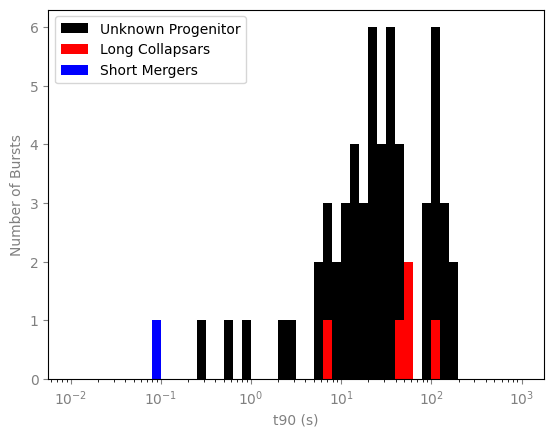

There are 5 known long collapsars, 0 known long mergers, 1 known short mergers, 0 known short collapsars, 0 known exotic, and 0 known isolated GRBs in Sample 6.
There are 48/64 bursts in total


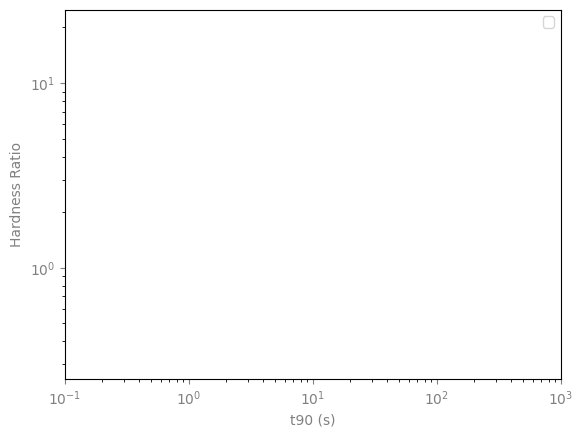

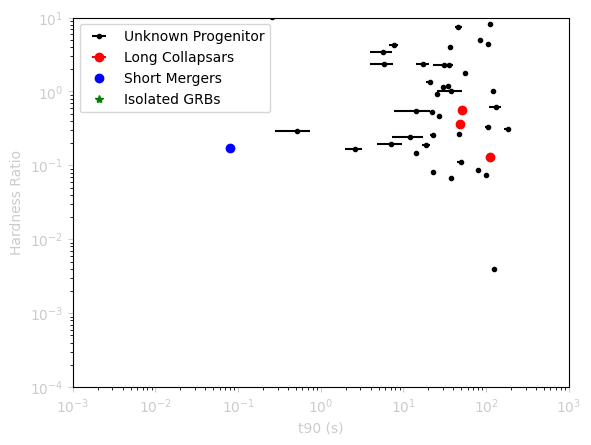

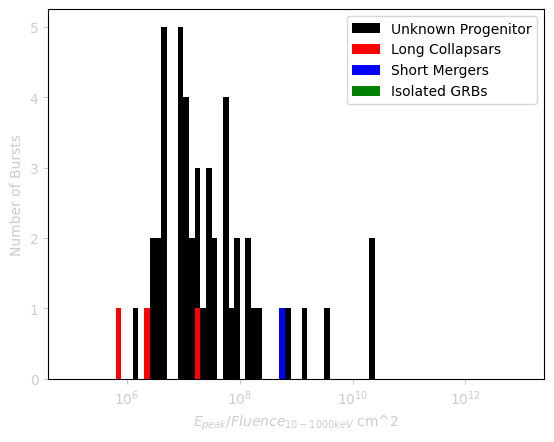

In [12]:
##Sample 6 Diagnositics##
#unknown_progenitor_edited_fermi_data=fermi_data
swift_unknown_progenitor_HR=[]
swift_unknown_progenitor_HR_err=np.zeros((1,2))
fermi_unknown_progenitor_HR=[]
fermi_unknown_progenitor_HR_err=np.zeros((1,2))
swift_unknown_progenitor_t90=[]
swift_unknown_progenitor_t90_err=[]
unknown_progenitor_t90=[]
unknown_progenitor_t90_err=[]
unknown_progenitor_Epeak_over_s=[]
unknown_progenitor_Epeak_over_s_err=[]
unknown_progenitor_Epeak=[]
unknown_progenitor_Epeak_err=[]
unknown_progenitor_flu=[]
unknown_progenitor_flu_err=[]
unknown_progenitor_redshift=[]
swift_long_merger_HR=[]
swift_long_merger_HR_err=np.zeros((1,2))
fermi_long_merger_HR=[]
fermi_long_merger_HR_err=np.zeros((1,2))
long_merger_t90=[]
long_merger_t90_err=[]
long_merger_Epeak_over_s=[]
long_merger_Epeak_over_s_err=[]
long_merger_Epeak=[]
long_merger_Epeak_err=[]
long_merger_flu=[]
long_merger_flu_err=[]
long_merger_redshift=[]
swift_short_merger_HR=[]
swift_short_merger_HR_err=np.zeros((1,2))
fermi_short_merger_HR=[]
fermi_short_merger_HR_err=np.zeros((1,2))
swift_short_merger_t90=[]
swift_short_merger_t90_err=[]
short_merger_t90=[]
short_merger_t90_err=[]
short_merger_Epeak_over_s=[]
short_merger_Epeak_over_s_err=[]
short_merger_Epeak=[]
short_merger_Epeak_err=[]
short_merger_flu=[]
short_merger_flu_err=[]
short_merger_redshift=[]
swift_long_collapsar_HR=[]
swift_long_collapsar_HR_err=np.zeros((1,2))
fermi_long_collapsar_HR=[]
fermi_long_collapsar_HR_err=np.zeros((1,2))
swift_long_collapsar_t90=[]
swift_long_collapsar_t90_err=[]
long_collapsar_t90=[]
long_collapsar_t90_err=[]
long_collapsar_Epeak_over_s=[]
long_collapsar_Epeak_over_s_err=[]
long_collapsar_Epeak=[]
long_collapsar_Epeak_err=[]
long_collapsar_flu=[]
long_collapsar_flu_err=[]
long_collapsar_redshift=[]
swift_short_collapsar_HR=[]
swift_short_collapsar_HR_err=np.zeros((1,2))
fermi_short_collapsar_HR=[]
fermi_short_collapsar_HR_err=np.zeros((1,2))
short_collapsar_t90=[]
short_collapsar_t90_err=[]
short_collapsar_Epeak_over_s=[]
short_collapsar_Epeak_over_s_err=[]
short_collapsar_Epeak=[]
short_collapsar_Epeak_err=[]
short_collapsar_flu=[]
short_collapsar_flu_err=[]
short_collapsar_redshift=[]
swift_exotic_HR=[]
swift_exotic_HR_err=np.zeros((1,2))
fermi_exotic_HR=[]
fermi_exotic_HR_err=np.zeros((1,2))
swift_isolated_HR=[]
swift_isolated_HR_err=np.zeros((1,2))
fermi_isolated_HR=[]
fermi_isolated_HR_err=np.zeros((1,2))
swift_isolated_t90=[]
swift_isolated_t90_err=[]
isolated_t90=[]
isolated_t90_err=[]
isolated_Epeak_over_s=[]
isolated_Epeak_over_s_err=[]
isolated_Epeak=[]
isolated_Epeak_err=[]
isolated_flu=[]
isolated_flu_err=[]
isolated_redshift=[]
exotic_t90=[]
exotic_t90_err=[]
exotic_Epeak_over_s=[]
exotic_Epeak_over_s_err=[]
exotic_Epeak=[]
exotic_Epeak_err=[]
exotic_flu=[]
exotic_flu_err=[]
exotic_redshift=[]
nbins=51
Redshift_Goldstein_Data=np.zeros((len(sample_6_data),11))
p=0
#
lc_mask=np.isin(sample_6_data['name'], \
                Overlap_Precursors["Long Collapsars"])
lc_sample_6_data=sample_6_data[lc_mask]
for i in lc_sample_6_data.index.to_list():
#     if valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 25_50kev '] != ' N/A '\
#         and valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),' 25_50kev '] != ' N/A ':
#         swift_long_collapsar_HR=np.append(swift_long_collapsar_HR, \
#             float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 50_100kev '])/\
#                             float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),\
#                                                     ' 25_50kev ']))
#         swift_long_collapsar_t90=np.append(swift_long_collapsar_t90, \
#                                            float(edited_swift_data.at[\
#                                         int(sample_6_data.at[i, 'Swift row']), \
#                                                                     '     T90      ']))
#     else: 
#         swift_long_collapsar_HR=np.append(swift_long_collapsar_HR, np.NaN)
#         swift_long_collapsar_t90=np.append(swift_long_collapsar_t90, np.NaN)
#     if edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '] !=\
#     'N/A':
#         swift_long_collapsar_t90_err = np.append(swift_long_collapsar_t90_err, \
#             edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '])
#     else: 
#         swift_long_collapsar_t90_err = np.append(swift_long_collapsar_t90_err, 0)
    fermi_long_collapsar_HR=np.append(fermi_long_collapsar_HR, Fermi_HR_func(sample_2_data, \
                                sample_6_data.at[i, 'Spectral Model'], \
                                            int(sample_6_data.at[i, 'Fermi row'])))
    long_collapsar_t90=np.append(long_collapsar_t90, \
                                 float(lc_sample_6_data.at[i, 't90']))
    long_collapsar_Epeak=np.append(long_collapsar_Epeak, getting_the_GBM_E_peak(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))
    long_collapsar_flu=np.append(long_collapsar_flu, float(sample_6_data.at[i, 'GBM fluence']))
    long_collapsar_Epeak_over_s=np.append(long_collapsar_Epeak_over_s, \
                        (getting_the_GBM_E_peak(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))/\
                                       float(sample_6_data.at[i, 'GBM fluence']))
    long_collapsar_Epeak_err=np.append(long_collapsar_Epeak, \
                                       getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))
    long_collapsar_flu_err=np.append(long_collapsar_flu_err, \
                                     float(sample_6_data.at[i, 'Fluence error']))
    long_collapsar_Epeak_over_s_err=np.append(long_collapsar_Epeak_over_s_err, \
                        (getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))/\
                                       float(sample_2_data.at[i, 'fluence   ']))
    long_collapsar_redshift=np.append(long_collapsar_redshift, \
                                         float(sample_6_data.at[i, 'Likely Redshift']))
    long_collapsar_t90_err=np.append(long_collapsar_t90_err, \
                            float(lc_sample_6_data.at[i, 't90_error']))
    Redshift_Goldstein_Data[p,0]=sample_6_data.at[i, 'name']
    Redshift_Goldstein_Data[p,1]=long_collapsar_Epeak_over_s[-1]
    Redshift_Goldstein_Data[p,2]=long_collapsar_Epeak_over_s_err[-1]
    Redshift_Goldstein_Data[p,3]=fermi_long_collapsar_HR[-1]
    Redshift_Goldstein_Data[p,4]=long_collapsar_t90[-1]
    Redshift_Goldstein_Data[p,5]=long_collapsar_t90_err[-1]
    Redshift_Goldstein_Data[p,6]=long_collapsar_Epeak[-1]
    Redshift_Goldstein_Data[p,7]=long_collapsar_Epeak_err[-1]
    Redshift_Goldstein_Data[p,8]=long_collapsar_flu[-1]
    Redshift_Goldstein_Data[p,9]=long_collapsar_flu_err[-1]
    Redshift_Goldstein_Data[p,10]=long_collapsar_redshift[-1]
    p=p+1
print(p)
long_collapsar_t90_err=np.where(lc_sample_6_data['t90_error'] != 'N/A', \
        lc_sample_6_data['t90_error'], 0)
if len(long_collapsar_t90_err)>0:
    for j in range(0, len(long_collapsar_t90_err)):
        long_collapsar_t90_err[j]=float(long_collapsar_t90_err[j])
#         swift_long_collapsar_t90_err[j]=float(swift_long_collapsar_t90_err[j])
sc_mask=np.isin(sample_6_data['name'], \
                Overlap_Precursors["Short Collapsars"])
sc_sample_6_data=sample_6_data[sc_mask]
for i in sc_sample_6_data.index.to_list():
#     if valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 25_50kev '] != ' N/A '\
#         and valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),' 25_50kev '] != ' N/A ':
#         swift_short_collapsar_HR=np.append(swift_short_collapsar_HR, \
#             float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 50_100kev '])/\
#                             float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),\
#                                                     ' 25_50kev ']))
#         swift_short_collapsar_t90=np.append(swift_short_collapsar_t90, \
#                                            float(edited_swift_data.at[\
#                                         int(sample_6_data.at[i, 'Swift row']), \
#                                                                     '     T90      ']))
#     else: 
#         swift_short_collapsar_HR=np.append(swift_short_collapsar_HR, np.NaN)
#         swift_short_collapsar_t90=np.append(swift_short_collapsar_t90, np.NaN)
#     if edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '] !=\
#     'N/A':
#         swift_short_collapsar_t90_err = np.append(swift_short_collapsar_t90_err, \
#             edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '])
#     else: 
#         swift_short_collapsar_t90_err = np.append(swift_short_collapsar_t90_err, 0)
    fermi_short_collapsar_HR=np.append(fermi_short_collapsar_HR, Fermi_HR_func(sample_2_data, \
                                sample_6_data.at[i, 'Spectral Model'], \
                                            int(sample_6_data.at[i, 'Fermi row'])))
    short_collapsar_t90=np.append(short_collapsar_t90, \
                                 float(sc_sample_6_data.at[i, 't90']))
    short_collapsar_Epeak=np.append(short_collapsar_Epeak, getting_the_GBM_E_peak(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))
    short_collapsar_flu=np.append(short_collapsar_flu, float(sample_6_data.at[i, 'GBM fluence']))
    short_collapsar_Epeak_over_s=np.append(short_collapsar_Epeak_over_s, \
                        (getting_the_GBM_E_peak(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))/\
                                       float(sample_6_data.at[i, 'GBM fluence']))
    short_collapsar_Epeak_err=np.append(short_collapsar_Epeak, \
                                       getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))
    short_collapsar_flu_err=np.append(short_collapsar_flu_err, \
                                     float(sample_6_data.at[i, 'Fluence error']))
    short_collapsar_Epeak_over_s_err=np.append(short_collapsar_Epeak_over_s_err, \
                        (getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))/\
                                       float(sample_2_data.at[i, 'fluence   ']))
    short_collapsar_redshift=np.append(short_collapsar_redshift, \
                                         float(sample_6_data.at[i, 'Likely Redshift']))
    short_collapsar_t90_err=np.append(short_collapsar_t90_err, \
                            float(sc_sample_6_data.at[i, 't90_error']))
    Redshift_Goldstein_Data[p,0]=sample_6_data.at[i, 'name']
    Redshift_Goldstein_Data[p,1]=short_collapsar_Epeak_over_s[-1]
    Redshift_Goldstein_Data[p,2]=short_collapsar_Epeak_over_s_err[-1]
    Redshift_Goldstein_Data[p,3]=fermi_short_collapsar_HR[-1]
    Redshift_Goldstein_Data[p,4]=short_collapsar_t90[-1]
    Redshift_Goldstein_Data[p,5]=short_collapsar_t90_err[-1]
    Redshift_Goldstein_Data[p,6]=short_collapsar_Epeak[-1]
    Redshift_Goldstein_Data[p,7]=short_collapsar_Epeak_err[-1]
    Redshift_Goldstein_Data[p,8]=short_collapsar_flu[-1]
    Redshift_Goldstein_Data[p,9]=short_collapsar_flu_err[-1]
    Redshift_Goldstein_Data[p,10]=short_collapsar_redshift[-1]
    p=p+1
short_collapsar_t90_err=np.where(sc_sample_6_data['t90_error'] != 'N/A', \
        sc_sample_6_data['t90_error'], 0)
if len(short_collapsar_t90_err)>0:
    for j in range(0, len(short_collapsar_t90_err)):
        short_collapsar_t90_err[j]=float(short_collapsar_t90_err[j])
#         swift_short_collapsar_t90_err[j]=float(swift_short_collapsar_t90_err[j])
lm_mask=np.isin(sample_6_data['name'], \
                Overlap_Precursors["Long Mergers"])
lm_sample_6_data=sample_6_data[lm_mask]
for i in lm_sample_6_data.index.to_list():
#     if valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 25_50kev '] != ' N/A '\
#         and valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),' 25_50kev '] != ' N/A ':
#         swift_long_merger_HR=np.append(swift_long_merger_HR, \
#             float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 50_100kev '])/\
#                             float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),\
#                                                     ' 25_50kev ']))
#         swift_long_merger_t90=np.append(swift_long_merger_t90, \
#                                            float(edited_swift_data.at[\
#                                         int(sample_6_data.at[i, 'Swift row']), \
#                                                                     '     T90      ']))
#     else: 
#         swift_long_merger_HR=np.append(swift_long_merger_HR, np.NaN)
#         swift_long_merger_t90=np.append(swift_long_merger_t90, np.NaN)
#     if edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '] !=\
#     'N/A':
#         swift_long_merger_t90_err = np.append(swift_long_merger_t90_err, \
#             edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '])
#     else: 
#         swift_long_merger_t90_err = np.append(swift_long_merger_t90_err, 0)
    fermi_long_merger_HR=np.append(fermi_long_merger_HR, Fermi_HR_func(sample_2_data, \
                                sample_6_data.at[i, 'Spectral Model'], \
                                            int(sample_6_data.at[i, 'Fermi row'])))
    long_merger_t90=np.append(long_merger_t90, \
                                 float(lm_sample_6_data.at[i, 't90']))
    long_merger_Epeak=np.append(long_merger_Epeak, getting_the_GBM_E_peak(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))
    long_merger_flu=np.append(long_merger_flu, float(sample_6_data.at[i, 'GBM fluence']))
    long_merger_Epeak_over_s=np.append(long_merger_Epeak_over_s, \
                        (getting_the_GBM_E_peak(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))/\
                                       float(sample_6_data.at[i, 'GBM fluence']))
    long_merger_Epeak_err=np.append(long_merger_Epeak, \
                                       getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))
    long_merger_flu_err=np.append(long_merger_flu_err, \
                                     float(sample_6_data.at[i, 'Fluence error']))
    long_merger_Epeak_over_s_err=np.append(long_merger_Epeak_over_s_err, \
                        (getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))/\
                                       float(sample_2_data.at[i, 'fluence   ']))
    long_merger_redshift=np.append(long_merger_redshift, \
                                         float(sample_6_data.at[i, 'Likely Redshift']))
    long_merger_t90_err=np.append(long_merger_t90_err, \
                            float(lm_sample_6_data.at[i, 't90_error']))
    Redshift_Goldstein_Data[p,0]=sample_6_data.at[i, 'name']
    Redshift_Goldstein_Data[p,1]=long_merger_Epeak_over_s[-1]
    Redshift_Goldstein_Data[p,2]=long_merger_Epeak_over_s_err[-1]
    Redshift_Goldstein_Data[p,3]=fermi_long_merger_HR[-1]
    Redshift_Goldstein_Data[p,4]=long_merger_t90[-1]
    Redshift_Goldstein_Data[p,5]=long_merger_t90_err[-1]
    Redshift_Goldstein_Data[p,6]=long_merger_Epeak[-1]
    Redshift_Goldstein_Data[p,7]=long_merger_Epeak_err[-1]
    Redshift_Goldstein_Data[p,8]=long_merger_flu[-1]
    Redshift_Goldstein_Data[p,9]=long_merger_flu_err[-1]
    Redshift_Goldstein_Data[p,10]=long_merger_redshift[-1]
    p=p+1
long_merger_t90_err=np.where(lm_sample_6_data['t90_error'] != 'N/A', \
        lm_sample_6_data['t90_error'], 0)
if len(long_merger_t90_err)>0:
    for j in range(0, len(long_merger_t90_err)):
        long_merger_t90_err[j]=float(long_merger_t90_err[j])
#         swift_long_merger_t90_err[j]=float(swift_long_merger_t90_err[j])
sm_mask=np.isin(sample_6_data['name'], \
                Overlap_Precursors["Short Mergers"])
sm_sample_6_data=sample_6_data[sm_mask]
for i in sm_sample_6_data.index.to_list():
#     if valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 25_50kev '] != ' N/A '\
#         and valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),' 25_50kev '] != ' N/A ':
#         swift_short_merger_HR=np.append(swift_short_merger_HR, \
#             float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 50_100kev '])/\
#                             float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),\
#                                                     ' 25_50kev ']))
#         swift_short_merger_t90=np.append(swift_short_merger_t90, \
#                                            float(edited_swift_data.at[\
#                                         int(sample_6_data.at[i, 'Swift row']), \
#                                                                     '     T90      ']))
#     else: 
#         swift_short_merger_HR=np.append(swift_short_merger_HR, np.NaN)
#         swift_short_merger_t90=np.append(swift_short_merger_t90, np.NaN)
#     if edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '] !=\
#     'N/A':
#         swift_short_merger_t90_err = np.append(swift_short_merger_t90_err, \
#             edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '])
#     else: 
#         swift_short_merger_t90_err = np.append(swift_short_merger_t90_err, 0)
    fermi_short_merger_HR=np.append(fermi_short_merger_HR, Fermi_HR_func(sample_2_data, \
                                sample_6_data.at[i, 'Spectral Model'], \
                                            int(sample_6_data.at[i, 'Fermi row'])))
    short_merger_t90=np.append(short_merger_t90, \
                                 float(sm_sample_6_data.at[i, 't90']))
    short_merger_Epeak=np.append(short_merger_Epeak, getting_the_GBM_E_peak(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))
    short_merger_flu=np.append(short_merger_flu, float(sample_6_data.at[i, 'GBM fluence']))
    short_merger_Epeak_over_s=np.append(short_merger_Epeak_over_s, \
                        (getting_the_GBM_E_peak(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))/\
                                       float(sample_6_data.at[i, 'GBM fluence']))
    short_merger_Epeak_err=np.append(short_merger_Epeak, \
                                       getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))
    short_merger_flu_err=np.append(short_merger_flu_err, \
                                     float(sample_6_data.at[i, 'Fluence error']))
    short_merger_Epeak_over_s_err=np.append(short_merger_Epeak_over_s_err, \
                        (getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))/\
                                       float(sample_2_data.at[i, 'fluence   ']))
    short_merger_redshift=np.append(short_merger_redshift, \
                                         float(sample_6_data.at[i, 'Likely Redshift']))
    short_merger_t90_err=np.append(short_merger_t90_err, \
                            float(sm_sample_6_data.at[i, 't90_error']))
    Redshift_Goldstein_Data[p,0]=sample_6_data.at[i, 'name']
    Redshift_Goldstein_Data[p,1]=short_merger_Epeak_over_s[-1]
    Redshift_Goldstein_Data[p,2]=short_merger_Epeak_over_s_err[-1]
    Redshift_Goldstein_Data[p,3]=fermi_short_merger_HR[-1]
    Redshift_Goldstein_Data[p,4]=short_merger_t90[-1]
    Redshift_Goldstein_Data[p,5]=short_merger_t90_err[-1]
    Redshift_Goldstein_Data[p,6]=short_merger_Epeak[-1]
    Redshift_Goldstein_Data[p,7]=short_merger_Epeak_err[-1]
    Redshift_Goldstein_Data[p,8]=short_merger_flu[-1]
    Redshift_Goldstein_Data[p,9]=short_merger_flu_err[-1]
    Redshift_Goldstein_Data[p,10]=short_merger_redshift[-1]
    p=p+1
short_merger_t90_err=np.where(sm_sample_6_data['t90_error'] != 'N/A', \
        sm_sample_6_data['t90_error'], 0)
if len(short_merger_t90_err)>0:
    for j in range(0, len(short_merger_t90_err)):
        short_merger_t90_err[j]=float(short_merger_t90_err[j])
#         swift_short_merger_t90_err[j]=float(swift_short_merger_t90_err[j])
exo_mask=np.isin(sample_6_data['name'], \
                Overlap_Precursors["Potentially Exotic"])
exo_sample_6_data=sample_6_data[exo_mask]
for i in exo_sample_6_data.index.to_list():
#     if valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 25_50kev '] != ' N/A '\
#         and valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),' 25_50kev '] != ' N/A ':
#         swift_exotic_HR=np.append(swift_exotic_HR, \
#             float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 50_100kev '])/\
#                             float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),\
#                                                     ' 25_50kev ']))
#         swift_exotic_t90=np.append(swift_exotic_t90, \
#                                            float(edited_swift_data.at[\
#                                         int(sample_6_data.at[i, 'Swift row']), \
#                                                                     '     T90      ']))
#     else: 
#         swift_exotic_HR=np.append(swift_exotic_HR, np.NaN)
#         swift_exotic_t90=np.append(swift_exotic_t90, np.NaN)
#     if edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '] !=\
#     'N/A':
#         swift_exotic_t90_err = np.append(swift_exotic_t90_err, \
#             edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '])
#     else: 
#         swift_exotic_t90_err = np.append(swift_exotic_t90_err, 0)
    fermi_exotic_HR=np.append(fermi_exotic_HR, Fermi_HR_func(sample_2_data, \
                                sample_6_data.at[i, 'Spectral Model'], \
                                            int(sample_6_data.at[i, 'Fermi row'])))
    exotic_t90=np.append(exotic_t90, \
                                 float(exo_sample_6_data.at[i, 't90']))
    exotic_Epeak=np.append(exotic_Epeak, getting_the_GBM_E_peak(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))
    exotic_flu=np.append(exotic_flu, float(sample_6_data.at[i, 'GBM fluence']))
    exotic_Epeak_over_s=np.append(exotic_Epeak_over_s, \
                        (getting_the_GBM_E_peak(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))/\
                                       float(sample_6_data.at[i, 'GBM fluence']))
    exotic_Epeak_err=np.append(exotic_Epeak, \
                                       getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))
    exotic_flu_err=np.append(exotic_flu_err, \
                                     float(sample_6_data.at[i, 'Fluence error']))
    exotic_Epeak_over_s_err=np.append(exotic_Epeak_over_s_err, \
                        (getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))/\
                                       float(sample_2_data.at[i, 'fluence   ']))
    exotic_redshift=np.append(exotic_redshift, \
                                         float(sample_6_data.at[i, 'Likely Redshift']))
    exotic_t90_err=np.append(exotic_t90_err, \
                            float(exo_sample_6_data.at[i, 't90_error']))
    Redshift_Goldstein_Data[p,0]=sample_6_data.at[i, 'name']
    Redshift_Goldstein_Data[p,1]=exotic_Epeak_over_s[-1]
    Redshift_Goldstein_Data[p,2]=exotic_Epeak_over_s_err[-1]
    Redshift_Goldstein_Data[p,3]=fermi_exotic_HR[-1]
    Redshift_Goldstein_Data[p,4]=exotic_t90[-1]
    Redshift_Goldstein_Data[p,5]=exotic_t90_err[-1]
    Redshift_Goldstein_Data[p,6]=exotic_Epeak[-1]
    Redshift_Goldstein_Data[p,7]=exotic_Epeak_err[-1]
    Redshift_Goldstein_Data[p,8]=exotic_flu[-1]
    Redshift_Goldstein_Data[p,9]=exotic_flu_err[-1]
    Redshift_Goldstein_Data[p,10]=exotic_redshift[-1]
    p=p+1
exotic_t90_err=np.where(exo_sample_6_data['t90_error'] != 'N/A', \
        exo_sample_6_data['t90_error'], 0)
if len(exotic_t90_err)>0:
    for j in range(0, len(exotic_t90_err)):
        exotic_t90_err[j]=float(exotic_t90_err[j])
#         swift_exotic_t90_err[j]=float(swift_exotic_t90_err[j])
        
iso_mask=np.isin(sample_6_data['name'], \
                Overlap_Precursors["Galactic Detected"])
iso_sample_6_data=sample_6_data[iso_mask]
for i in iso_sample_6_data.index.to_list():
#     if valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 25_50kev '] != ' N/A '\
#         and valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),' 25_50kev '] != ' N/A ':
#         swift_isolated_HR=np.append(swift_isolated_HR, \
#             float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 50_100kev '])/\
#                             float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),\
#                                                     ' 25_50kev ']))
#         swift_isolated_t90=np.append(swift_isolated_t90, \
#                                            float(edited_swift_data.at[\
#                                         int(sample_6_data.at[i, 'Swift row']), \
#                                                                     '     T90      ']))
#     else: 
#         swift_isolated_HR=np.append(swift_isolated_HR, np.NaN)
#         swift_isolated_t90=np.append(swift_isolated_t90, np.NaN)
#     if edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '] !=\
#     'N/A':
#         swift_isolated_t90_err = np.append(swift_isolated_t90_err, \
#             edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '])
#     else: 
#         swift_isolated_t90_err = np.append(swift_isolated_t90_err, 0)
    fermi_isolated_HR=np.append(fermi_isolated_HR, Fermi_HR_func(sample_2_data, \
                                sample_6_data.at[i, 'Spectral Model'], \
                                            int(sample_6_data.at[i, 'Fermi row'])))
    isolated_t90=np.append(isolated_t90, \
                                 float(iso_sample_6_data.at[i, 't90']))
    isolated_Epeak=np.append(isolated_Epeak, getting_the_GBM_E_peak(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))
    isolated_flu=np.append(isolated_flu, float(sample_6_data.at[i, 'GBM fluence']))
    isolated_Epeak_over_s=np.append(isolated_Epeak_over_s, \
                        (getting_the_GBM_E_peak(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))/\
                                       float(sample_6_data.at[i, 'GBM fluence']))
    isolated_Epeak_err=np.append(isolated_Epeak, \
                                       getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))
    isolated_flu_err=np.append(isolated_flu_err, \
                                     float(sample_6_data.at[i, 'Fluence error']))
    isolated_Epeak_over_s_err=np.append(isolated_Epeak_over_s_err, \
                        (getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))/\
                                       float(sample_2_data.at[i, 'fluence   ']))
    isolated_redshift=np.append(isolated_redshift, \
                                         float(sample_6_data.at[i, 'Likely Redshift']))
    isolated_t90_err=np.append(isolated_t90_err, \
                            float(iso_sample_6_data.at[i, 't90_error']))
    Redshift_Goldstein_Data[p,0]=sample_6_data.at[i, 'name']
    Redshift_Goldstein_Data[p,1]=isolated_Epeak_over_s[-1]
    Redshift_Goldstein_Data[p,2]=isolated_Epeak_over_s_err[-1]
    Redshift_Goldstein_Data[p,3]=fermi_isolated_HR[-1]
    Redshift_Goldstein_Data[p,4]=isolated_t90[-1]
    Redshift_Goldstein_Data[p,5]=isolated_t90_err[-1]
    Redshift_Goldstein_Data[p,6]=isolated_Epeak[-1]
    Redshift_Goldstein_Data[p,7]=isolated_Epeak_err[-1]
    Redshift_Goldstein_Data[p,8]=isolated_flu[-1]
    Redshift_Goldstein_Data[p,9]=isolated_flu_err[-1]
    Redshift_Goldstein_Data[p,10]=isolated_redshift[-1]
    p=p+1
isolated_t90_err=np.where(iso_sample_6_data['t90_error'] != 'N/A', \
        iso_sample_6_data['t90_error'], 0)
if len(isolated_t90_err)>0:
    for j in range(0, len(isolated_t90_err)):
        isolated_t90_err[j]=float(isolated_t90_err[j])
#         swift_isolated_t90_err[j]=float(swift_isolated_t90_err[j])
        
unknown_progenitor_sample_6_data=sample_6_data[~(lm_mask|lc_mask|sm_mask|sc_mask|exo_mask)]
for i in unknown_progenitor_sample_6_data.index.to_list():
#     if valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 25_50kev '] != ' N/A '\
#         and valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),' 25_50kev '] != ' N/A ':
#         swift_unknown_progenitor_HR=np.append(swift_unknown_progenitor_HR, \
#             float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 50_100kev '])/\
#                             float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),\
#                                                     ' 25_50kev ']))
#         swift_unknown_progenitor_t90=np.append(swift_unknown_progenitor_t90, \
#                                            float(edited_swift_data.at[\
#                                         int(sample_6_data.at[i, 'Swift row']), \
#                                                                     '     T90      ']))
#     else: 
#         swift_unknown_progenitor_HR=np.append(swift_unknown_progenitor_HR, np.NaN)
#         swift_unknown_progenitor_t90=np.append(swift_unknown_progenitor_t90, np.NaN)
#     if edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '] !=\
#     'N/A':
#         swift_unknown_progenitor_t90_err = np.append(swift_unknown_progenitor_t90_err, \
#             edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '])
#     else: 
#         swift_unknown_progenitor_t90_err = np.append(swift_unknown_progenitor_t90_err, 0)
    fermi_unknown_progenitor_HR=np.append(fermi_unknown_progenitor_HR, Fermi_HR_func(sample_2_data, \
                                sample_6_data.at[i, 'Spectral Model'], \
                                            int(sample_6_data.at[i, 'Fermi row'])))
    unknown_progenitor_t90=np.append(unknown_progenitor_t90, \
                                 float(unknown_progenitor_sample_6_data.at[i, 't90']))
    unknown_progenitor_Epeak=np.append(unknown_progenitor_Epeak, getting_the_GBM_E_peak(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))
    unknown_progenitor_flu=np.append(unknown_progenitor_flu, float(sample_6_data.at[i, 'GBM fluence']))
    unknown_progenitor_Epeak_over_s=np.append(unknown_progenitor_Epeak_over_s, \
                        (getting_the_GBM_E_peak(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))/\
                                       float(sample_6_data.at[i, 'GBM fluence']))
    unknown_progenitor_Epeak_err=np.append(unknown_progenitor_Epeak, \
                                       getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))
    unknown_progenitor_flu_err=np.append(unknown_progenitor_flu_err, \
                                     float(sample_6_data.at[i, 'Fluence error']))
    unknown_progenitor_Epeak_over_s_err=np.append(unknown_progenitor_Epeak_over_s_err, \
                        (getting_the_GBM_E_peak_err(sample_2_data, \
                                    sample_6_data.at[i, 'Spectral Model'], \
                                               sample_6_data.at[i, 'Fermi row']))/\
                                       float(sample_2_data.at[i, 'fluence   ']))
    unknown_progenitor_redshift=np.append(unknown_progenitor_redshift, \
                                         float(sample_6_data.at[i, 'Likely Redshift']))
    unknown_progenitor_t90_err=np.append(unknown_progenitor_t90_err, \
                            float(unknown_progenitor_sample_6_data.at[i, 't90_error']))
    Redshift_Goldstein_Data[p,0]=sample_6_data.at[i, 'name']
    Redshift_Goldstein_Data[p,1]=unknown_progenitor_Epeak_over_s[-1]
    Redshift_Goldstein_Data[p,2]=unknown_progenitor_Epeak_over_s_err[-1]
    Redshift_Goldstein_Data[p,3]=fermi_unknown_progenitor_HR[-1]
    Redshift_Goldstein_Data[p,4]=unknown_progenitor_t90[-1]
    Redshift_Goldstein_Data[p,5]=unknown_progenitor_t90_err[-1]
    Redshift_Goldstein_Data[p,6]=unknown_progenitor_Epeak[-1]
    Redshift_Goldstein_Data[p,7]=unknown_progenitor_Epeak_err[-1]
    Redshift_Goldstein_Data[p,8]=unknown_progenitor_flu[-1]
    Redshift_Goldstein_Data[p,9]=unknown_progenitor_flu_err[-1]
    Redshift_Goldstein_Data[p,10]=unknown_progenitor_redshift[-1]
    p=p+1
unknown_progenitor_t90_err=np.where(unknown_progenitor_sample_6_data['t90_error'] != 'N/A', \
        unknown_progenitor_sample_6_data['t90_error'], 0)
if len(unknown_progenitor_t90_err)>0:
    for j in range(0, len(unknown_progenitor_t90_err)):
        unknown_progenitor_t90_err[j]=float(unknown_progenitor_t90_err[j])
#         swift_unknown_progenitor_t90_err[j]=float(swift_unknown_progenitor_t90_err[j])
swift_long_merger_HR_err=swift_long_merger_HR_err[1:]
swift_long_collapsar_HR_err=swift_long_collapsar_HR_err[1:]
swift_short_merger_HR_err=swift_short_merger_HR_err[1:]
swift_short_collapsar_HR_err=swift_short_collapsar_HR_err[1:]
swift_exotic_HR_err=swift_exotic_HR_err[1:]
swift_isolated_HR_err=swift_isolated_HR_err[1:]
swift_unknown_progenitor_HR_err=swift_unknown_progenitor_HR_err[1:]
bins=np.logspace(np.log10(0.01),np.log10(1000), nbins)
plt.hist(unknown_progenitor_t90, bins=bins, color='k')
plt.hist(long_collapsar_t90, bins=bins, color='r')
# plt.hist(long_merger_t90, bins=bins)
# plt.hist(short_collapsar_t90, bins=bins)
plt.hist(short_merger_t90, bins=bins, color='b')
# plt.hist(exotic_t90, bins=bins)
plt.hist(isolated_t90, bins=bins, color='g')
plt.xscale('log')
plt.tick_params(axis='x', colors='0.5')
plt.tick_params(axis='y', colors='0.5')
plt.legend(['Unknown Progenitor', 'Long Collapsars', 'Short Mergers'])#, 'Exotic'])
plt.xlabel("t90 (s)", color="0.5")
plt.ylabel("Number of Bursts", color="0.5")
plt.show()
print("There are {} known long collapsars, {} known long \
mergers, {} known short mergers, {} known short collapsars, \
{} known exotic, and {} known isolated GRBs in Sample 6.".\
format(len(long_collapsar_t90), len(long_merger_t90), \
       len(short_merger_t90), len(short_collapsar_t90), len(exotic_t90), len(isolated_t90)))
print('There are {}/{} bursts in total'.format(np.count_nonzero(\
                                                ~np.isnan(swift_long_collapsar_HR))\
        +np.count_nonzero(~np.isnan(fermi_long_merger_HR))+\
        np.count_nonzero(~np.isnan(fermi_short_merger_HR))+\
        np.count_nonzero(~np.isnan(fermi_short_collapsar_HR))+\
        np.count_nonzero(~np.isnan(fermi_exotic_HR))+\
        np.count_nonzero(~np.isnan(fermi_isolated_HR))+\
                                        np.count_nonzero(~np.isnan(fermi_unknown_progenitor_HR)), \
                                              len(sample_6_data)))
# plt.errorbar(x=swift_unknown_progenitor_t90, y=swift_unknown_progenitor_HR, \
#              yerr=np.transpose(swift_unknown_progenitor_HR_err), \
#              xerr=unknown_progenitor_t90_err, \
#              marker=".", color='k', ls='none')
# plt.errorbar(x=swift_long_collapsar_t90, y=swift_long_collapsar_HR, \
#              yerr=np.transpose(swift_long_collapsar_HR_err), \
# #              xerr=swift_long_collapsar_t90_err,\
#              marker="o", color='r', ls='none')
# plt.errorbar(x=swift_short_merger_t90, y=swift_short_merger_HR, \
#              yerr=np.transpose(swift_short_merger_HR_err), \
# #              xerr=swift_long_collapsar_t90_err,\
#              marker="o", color='b', ls='none')
# plt.errorbar(x=swift_isolated_t90, y=swift_isolated_HR, \
#              yerr=np.transpose(swift_isolated_HR_err), \
# #              xerr=swift_long_collapsar_t90_err,\
#              marker="o", color='g', ls='none')
plt.axis([0.1, 1000, 0.25, 25])
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='x', colors='0.5')
plt.tick_params(axis='y', colors='0.5')
plt.legend(['Unknown Progenitor', 'Long Collapsars', 'Short Mergers', "Isolated GRBs"])
plt.xlabel("t90 (s)", color="0.5")
plt.ylabel("Hardness Ratio", color="0.5")
plt.show()
plt.errorbar(x=unknown_progenitor_t90, y=fermi_unknown_progenitor_HR,\
#              yerr=np.transpose(unknown_progenitor_HR_err), \
             xerr=unknown_progenitor_t90_err, \
             marker=".", color='k', ls='none')
plt.errorbar(x=long_collapsar_t90, y=fermi_long_collapsar_HR, \
#              yerr=np.transpose(long_collapsar_HR_err),
             xerr=long_collapsar_t90_err,\
             marker="o", ls='none', color='r')
# plt.errorbar(x=long_merger_t90, y=long_merger_HR, \
# #              yerr=np.transpose(long_merger_HR_err), xerr=long_merger_t90_err,\
#              marker="*", ls='none')
# plt.errorbar(x=short_collapsar_t90, y=short_collapsar_HR, \
# #              yerr=np.transpose(short_collapsar_HR_err), xerr=short_collapsar_t90_err,\
#              marker="^", ls='none')
plt.errorbar(x=short_merger_t90, y=fermi_short_merger_HR, \
#              yerr=np.transpose(short_merger_HR_err), xerr=short_merger_t90_err, \
             marker="o", ls='none', color='b')
# plt.errorbar(x=exotic_t90, y=exotic_HR, yerr=np.transpose(exotic_HR_err), \
#              xerr=exotic_t90_err, marker="o", ls='none')
plt.errorbar(x=isolated_t90, y=fermi_isolated_HR, \
#              yerr=np.transpose(short_merger_HR_err), xerr=short_merger_t90_err, \
             marker="*", ls='none', color='g')
plt.axis([0.001, 1000, 1e-4, 10])
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='x', colors='0.8')
plt.tick_params(axis='y', colors='0.8')
plt.legend(['Unknown Progenitor', 'Long Collapsars', 'Short Mergers', "Isolated GRBs"])
plt.xlabel("t90 (s)", color="0.8")
plt.ylabel("Hardness Ratio", color="0.8")
plt.show()

new_bins=np.logspace(5,13, 81)
plt.hist(unknown_progenitor_Epeak_over_s, bins=new_bins, color='k')
plt.hist(long_collapsar_Epeak_over_s, bins=new_bins, color='r')
# plt.hist(long_merger_Epeak_over_s, bins=new_bins)
# plt.hist(short_collapsar_Epeak_over_s, bins=new_bins)
plt.hist(short_merger_Epeak_over_s, bins=new_bins, color='b')
# plt.hist(exotic_t90, bins=bins)
plt.hist(isolated_Epeak_over_s, bins=new_bins, color='g')
plt.xscale('log')
plt.tick_params(axis='x', colors='0.8')
plt.tick_params(axis='y', colors='0.8')
plt.legend(['Unknown Progenitor', 'Long Collapsars', 'Short Mergers', "Isolated GRBs"])
plt.xlabel(r"$E_{peak}$/$Fluence_{10-1000keV}$ cm^2", color="0.8")
plt.ylabel("Number of Bursts", color="0.8")
plt.show()
Goldstein_Sample_6_Data=pd.DataFrame(Redshift_Goldstein_Data, columns=["Name",\
                                        "Peak E. over Flue.", "E_P_Over_S_Err",\
                                        "Hardness Ratio", "t90", "t90_err", "Peak_E",\
                                        "Peak_E_Err", "Fluence", "Fluence_Err", "Redshift"])
Goldstein_Sample_6_Data.to_excel("Goldstein_Sample_6_Data.xlsx")